In [24]:
import numpy as np
import matplotlib.pyplot as plt
import tidy3d as td
import tidy3d.web as web


# --- 1. Material Definitions ---
# Using fixed indices for 1550nm for simplicity

wavelength =  1.55                              # Central wavelength
wv_points = 50                   # number of wavelength wv_points
width_220 = 0.390
width_300 = 0.310               # Anchos optimizados para tener single mode regimen
MMI_L_points = 4
MMI_W_points = 4
n_si = 3.475
n_sio2 = 1.458
MMI_L_optimized = 7.8
MMI_W_optimized = 3
taper_width = 0.8
Initial_pos = -11



sweep_wavelength = np.linspace(1.5,1.6,wv_points)  # Sweep on wavelengths
sweep_freq = td.C_0 / sweep_wavelength          # Sweep on Frequencies
sweep_MMI_L = np.linspace(MMI_L_optimized-0.3,MMI_L_optimized+0.3,MMI_L_points)
sweep_MMI_W = np.linspace(MMI_W_optimized-0.15,MMI_W_optimized+0.15,MMI_W_points)
dinstance_tapers = sweep_MMI_W/2



bandwidth = sweep_wavelength[-1]-sweep_wavelength[0]

mat_si = td.material_library["cSi"]["Li1993_293K"] # Material trace permitivity model for crystaline Silicon
mat_sio2 = td.material_library["SiO2"]["Horiba"]   # Material trace permitivity model for crystaline Silica


web.configure("U7IS5Q1AW3qYVxPAAQDE7vgxaTz6Kt6aI9AioPZUajVRQQ2o")

Configuration saved successfully.


In [25]:
def build_MMI_simulation(
    MMI_length = np.array([MMI_L_optimized]),
    MMI_width = np.array([MMI_W_optimized]),
    width_single_mode=np.array([width_220,width_300]),
    thickness=np.array([0.22,0.3]),
    wavelength = np.array([1.55]),
):

    # Frequency
    freq = td.C_0 / wavelength

    # Materials
    core = mat_si
    clad = mat_sio2

    # --- We define the simulation data array and simulation objects for the two different sweeps----

    sim_data_arr = [[[]],[[]]] # Simulation data for 220nm and 300nm, Length sweep and Width sweep
    sim_arr = [[[]],[[]]]      # Simulation objects for 220nm and 300nm , Length sweep and Width sweep
    estimate = 0

    #--- Define Sources ---
    freq0 = td.C_0 / wavelength.mean()
    fwidth = (td.C_0 / wavelength.min()) - (td.C_0 / wavelength.max())



    for (thick_idx,thick) in enumerate(thickness):
        for (length_idx,length_values) in enumerate(MMI_length):
            for (width_idx,width_values) in enumerate(MMI_width):

                ## Definicion de la fuente ##
                source1 = td.ModeSource(
                    name = 'Mode_source',
                    center = [Initial_pos-3.5, 0, 0],
                    size = [0, 4, 4],
                    source_time = td.GaussianPulse(freq0 = freq0, fwidth = fwidth, ),
                    direction = '+',
                    mode_spec = td.ModeSpec(num_modes = 1, target_neff = n_si, sort_spec = {'filter_reference' : 0, 'filter_order':'over', 'sort_order':'ascending', 'track_freq':'central'}, group_index_step = True, ),
                )

                ## Definicion de los monitores ##

                Longitudinal = td.FieldMonitor(
                    name = 'Longitudinal',
                    size = [td.inf, 7.75, 0],
                    freqs = freq,
                )

                IN = td.FieldMonitor(
                    name = 'IN',
                    center = [Initial_pos-3.5, 0, 0],
                    size = [0, 4, 4],
                    freqs = freq,
                )

                OUT1 = td.FieldMonitor(
                    name = 'OUT1',
                    center = [length_values + Initial_pos + 3, dinstance_tapers[width_idx] / 2, 0],
                    size = [0, 1, 1],
                    freqs = freq,
                )

                OUT2 = td.FieldMonitor(
                    name = 'OUT2',
                    center = [length_values + Initial_pos + 3, -dinstance_tapers[width_idx] / 2, 0],
                    size = [0, 1, 1],
                    freqs = freq,
                )


                ## Definicion de las estructuras ##


                ## For a Strip
                Xmin_Strip= (-100)
                Xmax_Strip= (-2+Initial_pos)

                Ymin_Strip= (-width_single_mode[thick_idx]/2)
                Ymax_Strip= (width_single_mode[thick_idx]/2)

                Zmin_Strip= (-thick/2)
                Zmax_Strip= (thick/2)

                Strip = td.Structure(
                    geometry = td.Box(center = [(Xmax_Strip+Xmin_Strip)/2, (Ymax_Strip+Ymin_Strip)/2, (Zmax_Strip+Zmin_Strip)/2], size = [Xmax_Strip-Xmin_Strip, Ymax_Strip-Ymin_Strip, Zmax_Strip-Zmin_Strip], ),
                    name = 'Strip',
                    medium = core
                )



                 ## For the MMI

                Xmin_MMI= Initial_pos
                Xmax_MMI= length_values+Initial_pos

                Ymin_MMI= -width_values/2
                Ymax_MMI= width_values/2

                Zmin_MMI= (-thick/2)
                Zmax_MMI= (thick/2)

                MMI = td.Structure(
                    geometry = td.Box(center = [(Xmax_MMI+Xmin_MMI)/2, (Ymax_MMI+Ymin_MMI)/2, (Zmax_MMI+Zmin_MMI)/2], size = [Xmax_MMI-Xmin_MMI, Ymax_MMI-Ymin_MMI, Zmax_MMI-Zmin_MMI]),
                    name = 'MMI',
                    medium = core
                )


                ## For the Taper In

                Xv1_Taper_IN =-2+Initial_pos
                Yv1_Taper_IN =-width_single_mode[thick_idx]/2

                Xv2_Taper_IN = Initial_pos
                Yv2_Taper_IN =-taper_width/2

                Xv3_Taper_IN = Initial_pos
                Yv3_Taper_IN = taper_width/2

                Xv4_Taper_IN = -2 + Initial_pos
                Yv4_Taper_IN = width_single_mode[thick_idx] / 2

                Zmin_Taper_IN= (-thick/2)
                Zmax_Taper_IN= (thick/2)


                Taper_IN = td.Structure(
                    geometry = td.PolySlab(slab_bounds = [Zmin_Taper_IN, Zmax_Taper_IN], vertices = [[Xv1_Taper_IN, Yv1_Taper_IN], [Xv2_Taper_IN, Yv2_Taper_IN], [Xv3_Taper_IN, Yv3_Taper_IN], [Xv4_Taper_IN, Yv4_Taper_IN]]),
                    name = 'Taper',
                    medium = core
                )

                 ## For the Taper OUT 1

                Xv1_Taper_OUT_1 = length_values+Initial_pos+2
                Yv1_Taper_OUT_1 =-width_single_mode[thick_idx]/2-dinstance_tapers[width_idx]/2

                Xv2_Taper_OUT_1 = length_values+Initial_pos
                Yv2_Taper_OUT_1 =-dinstance_tapers[width_idx]/2-taper_width/2

                Xv3_Taper_OUT_1 = length_values+Initial_pos
                Yv3_Taper_OUT_1 = -dinstance_tapers[width_idx]/2+taper_width/2

                Xv4_Taper_OUT_1 = length_values+Initial_pos+2
                Yv4_Taper_OUT_1 = -dinstance_tapers[width_idx]/2+width_single_mode[thick_idx]/2

                Zmin_Taper_OUT_1= (-thick/2)
                Zmax_Taper_OUT_1= (thick/2)



                Taper_out1 = td.Structure(
                    geometry = td.PolySlab(slab_bounds = [Zmin_Taper_OUT_1, Zmax_Taper_OUT_1], vertices = [[Xv1_Taper_OUT_1, Yv1_Taper_OUT_1], [Xv2_Taper_OUT_1, Yv2_Taper_OUT_1], [Xv3_Taper_OUT_1, Yv3_Taper_OUT_1], [Xv4_Taper_OUT_1, Yv4_Taper_OUT_1]]),
                    name = 'Taper_out1',
                    medium = core
                )


                ## For the Taper OUT 2

                Xv1_Taper_OUT_2 = length_values+Initial_pos+2
                Yv1_Taper_OUT_2 =width_single_mode[thick_idx]/2+dinstance_tapers[width_idx]/2

                Xv2_Taper_OUT_2 = length_values+Initial_pos
                Yv2_Taper_OUT_2 =dinstance_tapers[width_idx]/2+taper_width/2

                Xv3_Taper_OUT_2 = length_values+Initial_pos
                Yv3_Taper_OUT_2 = dinstance_tapers[width_idx]/2-taper_width/2

                Xv4_Taper_OUT_2 = length_values+Initial_pos+2
                Yv4_Taper_OUT_2 = dinstance_tapers[width_idx]/2-width_single_mode[thick_idx]/2

                Zmin_Taper_OUT_2= (-thick/2)
                Zmax_Taper_OUT_2= (thick/2)


                Taper_out2 = td.Structure(
                    geometry = td.PolySlab(slab_bounds = [Zmin_Taper_OUT_2, Zmax_Taper_OUT_2], vertices = [[Xv1_Taper_OUT_2, Yv1_Taper_OUT_2], [Xv2_Taper_OUT_2, Yv2_Taper_OUT_2], [Xv3_Taper_OUT_2, Yv3_Taper_OUT_2], [Xv4_Taper_OUT_2, Yv4_Taper_OUT_2]]),
                    name = 'Taper_out2',
                    medium = core
                )


                ## for a Strip_out1

                Xmin_Strip_out1= length_values+Initial_pos+2
                Xmax_Strip_out1= length_values+100

                Ymin_Strip_out1= -dinstance_tapers[width_idx]/2-width_single_mode[thick_idx]/2
                Ymax_Strip_out1= width_single_mode[thick_idx]/2-dinstance_tapers[width_idx]/2

                Zmin_Strip_out1= (-thick/2)
                Zmax_Strip_out1= (thick/2)



                Strip_out1 = td.Structure(
                    geometry = td.Box(center = [(Xmax_Strip_out1+Xmin_Strip_out1)/2, (Ymax_Strip_out1+Ymin_Strip_out1)/2, (Zmax_Strip_out1+Zmin_Strip_out1)/2], size = [Xmax_Strip_out1-Xmin_Strip_out1, Ymax_Strip_out1-Ymin_Strip_out1, Zmax_Strip_out1-Zmin_Strip_out1]),
                    name = 'Strip_out1',
                    medium = core
                )

                ## for a Strip_out2

                Xmin_Strip_out2= length_values+Initial_pos+2
                Xmax_Strip_out2= length_values+100

                Ymin_Strip_out2= dinstance_tapers[width_idx]/2-width_single_mode[thick_idx]/2
                Ymax_Strip_out2= width_single_mode[thick_idx]/2+dinstance_tapers[width_idx]/2

                Zmin_Strip_out2= (-thick/2)
                Zmax_Strip_out2= (thick/2)


                Strip_out2 = td.Structure(
                    geometry = td.Box(center = [(Xmax_Strip_out2+Xmin_Strip_out2)/2, (Ymax_Strip_out2+Ymin_Strip_out2)/2, (Zmax_Strip_out2+Zmin_Strip_out2)/2], size = [Xmax_Strip_out2-Xmin_Strip_out2, Ymax_Strip_out2-Ymin_Strip_out2, Zmax_Strip_out2-Zmin_Strip_out2]),
                    name = 'Strip_out2',
                    medium = core
                )#Hasta aca todo bien



                # --- Simulation domain ---
                sim_arr[thick_idx][length_idx].append(td.Simulation(
                    center = [-3.5, 0, 0],
                    size=[23, 6, 6],  # x ignored for mode solver
                    monitors=[OUT1,OUT2,Longitudinal,IN],
                    sources=[source1],
                    structures=[Strip,Strip_out1,Strip_out2,MMI,Taper_IN,Taper_out1,Taper_out2],
                    medium=clad,
                    symmetry=(0, 0, 1),  # symmetry in z
                    run_time = {'quality_factor' : 1, 'source_factor' : 3},
                    grid_spec=td.GridSpec.auto(wavelength = wavelength.min(),min_steps_per_wvl = 11),
                ))

                Job = web.Job(simulation=sim_arr[thick_idx][length_idx][width_idx], task_name="my_sim")

                estimate+= Job.estimate_cost()

                sim_data_arr[thick_idx][length_idx].append(web.run(sim_arr[thick_idx][length_idx][width_idx], task_name='DC_FDTD'))

            sim_data_arr[thick_idx].append([])
            sim_arr[thick_idx].append([])

    print(f"Estimated Maximum Cost: {estimate}")

    return sim_data_arr, sim_arr


sim_data, sim = build_MMI_simulation(MMI_length = sweep_MMI_L,MMI_width=sweep_MMI_W,wavelength=sweep_wavelength)

13:56:41 Hora est. Pacífico, Sudamérica Created task 'my_sim' with resource_id  
                                        'fdve-0ddc9168-a611-42b7-a690-074c19da10
                                        e4' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=130298;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0ddc9168-a611-42b7-a690-074c19da10e4\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=130298;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0ddc9168-a611-42b7-a690-074c19da10e4\ch?]8;;\]8;id=6698;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0ddc9168-a611-42b7-a690-074c19da10e4\taskId]8;;\]8;id=130298;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0ddc9168-a611-42b7-a690-074c19da10e4\=]8;;\]8;id=6521;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0ddc9168-a611-42b7-a690-074c19da10e4\fdve]8;;\]8;id=130298;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0ddc9168-a611-42b7-a690-074c19da10e4\-0ddc9168-a611-42b7-a690-0]8;;\
                                        ]8;id=130298;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0ddc9168-a611-42b7-a690-074c19da10e4\74c19da10e4']8;;\.

                                        Task folder: ]8;id=785735;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

13:56:44 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.033.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

13:56:45 Hora est. Pacífico, Sudamérica Created task 'DC_FDTD' with resource_id 
                                        'fdve-f6a92a33-1244-4c79-8cb4-1b2c273f3a
                                        48' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=294415;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f6a92a33-1244-4c79-8cb4-1b2c273f3a48\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=294415;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f6a92a33-1244-4c79-8cb4-1b2c273f3a48\ch?]8;;\]8;id=232697;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f6a92a33-1244-4c79-8cb4-1b2c273f3a48\taskId]8;;\]8;id=294415;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f6a92a33-1244-4c79-8cb4-1b2c273f3a48\=]8;;\]8;id=849884;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f6a92a33-1244-4c79-8cb4-1b2c273f3a48\fdve]8;;\]8;id=294415;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f6a92a33-1244-4c79-8cb4-1b2c273f3a48\-f6a92a33-1244-4c79-8cb4-1]8;;\
                                        ]8;id=294415;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f6a92a33-1244-4c79-8cb4-1b2c273f3a48\b2c273f3a48']8;;\.

                                        Task folder: ]8;id=167424;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

13:56:47 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.033.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

13:56:48 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

13:56:56 Hora est. Pacífico, Sudamérica starting up solver

13:56:57 Hora est. Pacífico, Sudamérica running solver

13:57:12 Hora est. Pacífico, Sudamérica status = postprocess

13:57:18 Hora est. Pacífico, Sudamérica status = success

13:57:20 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=74936;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f6a92a33-1244-4c79-8cb4-1b2c273f3a48\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=74936;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f6a92a33-1244-4c79-8cb4-1b2c273f3a48\ch?]8;;\]8;id=292713;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f6a92a33-1244-4c79-8cb4-1b2c273f3a48\taskId]8;;\]8;id=74936;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f6a92a33-1244-4c79-8cb4-1b2c273f3a48\=]8;;\]8;id=576535;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f6a92a33-1244-4c79-8cb4-1b2c273f3a48\fdve]8;;\]8;id=74936;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f6a92a33-1244-4c79-8cb4-1b2c273f3a48\-f6a92a33-1244-4c79-8cb4-1]8;;\
                                        ]8;id=74936;https://tidy3d.simulation.cloud/workbench?taskId=fdve-f6a92a33-1244-4c79-8cb4-1b2c273f3a48\b2c273f3a48']8;;\.

13:57:30 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

13:57:31 Hora est. Pacífico, Sudamérica WARNING: Simulation final field decay   
                                        value of 0.00018 is greater than the    
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

                                        Created task 'my_sim' with resource_id  
                                        'fdve-204f2de8-5eda-49d3-b5ca-e80e7b1e4c
                                        c6' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=98694;https://tidy3d.simulation.cloud/workbench?taskId=fdve-204f2de8-5eda-49d3-b5ca-e80e7b1e4cc6\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=98694;https://tidy3d.simulation.cloud/workbench?taskId=fdve-204f2de8-5eda-49d3-b5ca-e80e7b1e4cc6\ch?]8;;\]8;id=546810;https://tidy3d.simulation.cloud/workbench?taskId=fdve-204f2de8-5eda-49d3-b5ca-e80e7b1e4cc6\taskId]8;;\]8;id=98694;https://tidy3d.simulation.cloud/workbench?taskId=fdve-204f2de8-5eda-49d3-b5ca-e80e7b1e4cc6\=]8;;\]8;id=973441;https://tidy3d.simulation.cloud/workbench?taskId=fdve-204f2de8-5eda-49d3-b5ca-e80e7b1e4cc6\fdve]8;;\]8;id=98694;https://tidy3d.simulation.cloud/workbench?taskId=fdve-204f2de8-5eda-49d3-b5ca-e80e7b1e4cc6\-204f2de8-5eda-49d3-b5ca-e]8;;\
                                        ]8;id=98694;https://tidy3d.simulation.cloud/workbench?taskId=fdve-204f2de8-5eda-49d3-b5ca-e80e7b1e4cc6\80e7b1e4cc6']8;;\.

                                        Task folder: ]8;id=692200;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

13:57:35 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.033.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-9c61c406-ea7f-42b6-963c-98088e6008
                                        60' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=942694;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9c61c406-ea7f-42b6-963c-98088e600860\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=942694;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9c61c406-ea7f-42b6-963c-98088e600860\ch?]8;;\]8;id=473402;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9c61c406-ea7f-42b6-963c-98088e600860\taskId]8;;\]8;id=942694;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9c61c406-ea7f-42b6-963c-98088e600860\=]8;;\]8;id=993809;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9c61c406-ea7f-42b6-963c-98088e600860\fdve]8;;\]8;id=942694;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9c61c406-ea7f-42b6-963c-98088e600860\-9c61c406-ea7f-42b6-963c-9]8;;\
                                        ]8;id=942694;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9c61c406-ea7f-42b6-963c-98088e600860\8088e600860']8;;\.

                                        Task folder: ]8;id=412381;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

13:57:37 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.033.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

13:57:38 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

13:57:47 Hora est. Pacífico, Sudamérica starting up solver

                                        running solver

13:58:03 Hora est. Pacífico, Sudamérica status = postprocess

13:58:08 Hora est. Pacífico, Sudamérica status = success

13:58:10 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=638566;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9c61c406-ea7f-42b6-963c-98088e600860\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=638566;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9c61c406-ea7f-42b6-963c-98088e600860\ch?]8;;\]8;id=844734;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9c61c406-ea7f-42b6-963c-98088e600860\taskId]8;;\]8;id=638566;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9c61c406-ea7f-42b6-963c-98088e600860\=]8;;\]8;id=435320;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9c61c406-ea7f-42b6-963c-98088e600860\fdve]8;;\]8;id=638566;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9c61c406-ea7f-42b6-963c-98088e600860\-9c61c406-ea7f-42b6-963c-9]8;;\
                                        ]8;id=638566;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9c61c406-ea7f-42b6-963c-98088e600860\8088e600860']8;;\.

13:58:26 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

                                        WARNING: Simulation final field decay   
                                        value of 0.00039 is greater than the    
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

                                        Created task 'my_sim' with resource_id  
                                        'fdve-08b9c727-0f4d-4885-97fc-ab0811e46a
                                        67' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=69714;https://tidy3d.simulation.cloud/workbench?taskId=fdve-08b9c727-0f4d-4885-97fc-ab0811e46a67\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=69714;https://tidy3d.simulation.cloud/workbench?taskId=fdve-08b9c727-0f4d-4885-97fc-ab0811e46a67\ch?]8;;\]8;id=785214;https://tidy3d.simulation.cloud/workbench?taskId=fdve-08b9c727-0f4d-4885-97fc-ab0811e46a67\taskId]8;;\]8;id=69714;https://tidy3d.simulation.cloud/workbench?taskId=fdve-08b9c727-0f4d-4885-97fc-ab0811e46a67\=]8;;\]8;id=915246;https://tidy3d.simulation.cloud/workbench?taskId=fdve-08b9c727-0f4d-4885-97fc-ab0811e46a67\fdve]8;;\]8;id=69714;https://tidy3d.simulation.cloud/workbench?taskId=fdve-08b9c727-0f4d-4885-97fc-ab0811e46a67\-08b9c727-0f4d-4885-97fc-a]8;;\
                                        ]8;id=69714;https://tidy3d.simulation.cloud/workbench?taskId=fdve-08b9c727-0f4d-4885-97fc-ab0811e46a67\b0811e46a67']8;;\.

                                        Task folder: ]8;id=374947;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

13:58:30 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-fa7821a9-a8b8-4725-b0a0-d4e59ad6ad
                                        28' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=195669;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fa7821a9-a8b8-4725-b0a0-d4e59ad6ad28\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=195669;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fa7821a9-a8b8-4725-b0a0-d4e59ad6ad28\ch?]8;;\]8;id=563283;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fa7821a9-a8b8-4725-b0a0-d4e59ad6ad28\taskId]8;;\]8;id=195669;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fa7821a9-a8b8-4725-b0a0-d4e59ad6ad28\=]8;;\]8;id=15104;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fa7821a9-a8b8-4725-b0a0-d4e59ad6ad28\fdve]8;;\]8;id=195669;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fa7821a9-a8b8-4725-b0a0-d4e59ad6ad28\-fa7821a9-a8b8-4725-b0a0-d]8;;\
                                        ]8;id=195669;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fa7821a9-a8b8-4725-b0a0-d4e59ad6ad28\4e59ad6ad28']8;;\.

                                        Task folder: ]8;id=807552;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

13:58:32 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

13:58:34 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

13:58:42 Hora est. Pacífico, Sudamérica starting up solver

                                        running solver

13:58:59 Hora est. Pacífico, Sudamérica status = postprocess

13:59:05 Hora est. Pacífico, Sudamérica status = success

13:59:07 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=310372;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fa7821a9-a8b8-4725-b0a0-d4e59ad6ad28\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=310372;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fa7821a9-a8b8-4725-b0a0-d4e59ad6ad28\ch?]8;;\]8;id=510550;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fa7821a9-a8b8-4725-b0a0-d4e59ad6ad28\taskId]8;;\]8;id=310372;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fa7821a9-a8b8-4725-b0a0-d4e59ad6ad28\=]8;;\]8;id=557053;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fa7821a9-a8b8-4725-b0a0-d4e59ad6ad28\fdve]8;;\]8;id=310372;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fa7821a9-a8b8-4725-b0a0-d4e59ad6ad28\-fa7821a9-a8b8-4725-b0a0-d]8;;\
                                        ]8;id=310372;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fa7821a9-a8b8-4725-b0a0-d4e59ad6ad28\4e59ad6ad28']8;;\.

13:59:17 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

13:59:18 Hora est. Pacífico, Sudamérica WARNING: Simulation final field decay   
                                        value of 0.000799 is greater than the   
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

                                        Created task 'my_sim' with resource_id  
                                        'fdve-e67295ab-52f2-495b-a280-5d97f95927
                                        57' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=244948;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e67295ab-52f2-495b-a280-5d97f9592757\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=244948;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e67295ab-52f2-495b-a280-5d97f9592757\ch?]8;;\]8;id=233501;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e67295ab-52f2-495b-a280-5d97f9592757\taskId]8;;\]8;id=244948;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e67295ab-52f2-495b-a280-5d97f9592757\=]8;;\]8;id=225093;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e67295ab-52f2-495b-a280-5d97f9592757\fdve]8;;\]8;id=244948;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e67295ab-52f2-495b-a280-5d97f9592757\-e67295ab-52f2-495b-a280-5]8;;\
                                        ]8;id=244948;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e67295ab-52f2-495b-a280-5d97f9592757\d97f9592757']8;;\.

                                        Task folder: ]8;id=181911;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

13:59:21 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

13:59:22 Hora est. Pacífico, Sudamérica Created task 'DC_FDTD' with resource_id 
                                        'fdve-a50d60af-3019-468c-9606-56b793ec98
                                        14' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=867018;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a50d60af-3019-468c-9606-56b793ec9814\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=867018;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a50d60af-3019-468c-9606-56b793ec9814\ch?]8;;\]8;id=134998;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a50d60af-3019-468c-9606-56b793ec9814\taskId]8;;\]8;id=867018;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a50d60af-3019-468c-9606-56b793ec9814\=]8;;\]8;id=393765;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a50d60af-3019-468c-9606-56b793ec9814\fdve]8;;\]8;id=867018;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a50d60af-3019-468c-9606-56b793ec9814\-a50d60af-3019-468c-9606-5]8;;\
                                        ]8;id=867018;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a50d60af-3019-468c-9606-56b793ec9814\6b793ec9814']8;;\.

                                        Task folder: ]8;id=72992;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

13:59:24 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

13:59:25 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

13:59:34 Hora est. Pacífico, Sudamérica starting up solver

                                        running solver

13:59:40 Hora est. Pacífico, Sudamérica status = postprocess

13:59:46 Hora est. Pacífico, Sudamérica status = success

13:59:48 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=903716;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a50d60af-3019-468c-9606-56b793ec9814\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=903716;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a50d60af-3019-468c-9606-56b793ec9814\ch?]8;;\]8;id=353963;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a50d60af-3019-468c-9606-56b793ec9814\taskId]8;;\]8;id=903716;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a50d60af-3019-468c-9606-56b793ec9814\=]8;;\]8;id=178968;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a50d60af-3019-468c-9606-56b793ec9814\fdve]8;;\]8;id=903716;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a50d60af-3019-468c-9606-56b793ec9814\-a50d60af-3019-468c-9606-5]8;;\
                                        ]8;id=903716;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a50d60af-3019-468c-9606-56b793ec9814\6b793ec9814']8;;\.

13:59:58 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

13:59:59 Hora est. Pacífico, Sudamérica WARNING: Simulation final field decay   
                                        value of 0.000376 is greater than the   
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

                                        Created task 'my_sim' with resource_id  
                                        'fdve-ff3106ce-6aa1-4c2c-a9ec-2e39125bb2
                                        d3' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=702891;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ff3106ce-6aa1-4c2c-a9ec-2e39125bb2d3\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=702891;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ff3106ce-6aa1-4c2c-a9ec-2e39125bb2d3\ch?]8;;\]8;id=189780;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ff3106ce-6aa1-4c2c-a9ec-2e39125bb2d3\taskId]8;;\]8;id=702891;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ff3106ce-6aa1-4c2c-a9ec-2e39125bb2d3\=]8;;\]8;id=869787;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ff3106ce-6aa1-4c2c-a9ec-2e39125bb2d3\fdve]8;;\]8;id=702891;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ff3106ce-6aa1-4c2c-a9ec-2e39125bb2d3\-ff3106ce-6aa1-4c2c-a9ec-2]8;;\
                                        ]8;id=702891;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ff3106ce-6aa1-4c2c-a9ec-2e39125bb2d3\e39125bb2d3']8;;\.

                                        Task folder: ]8;id=367602;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

14:00:02 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.033.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

14:00:03 Hora est. Pacífico, Sudamérica Created task 'DC_FDTD' with resource_id 
                                        'fdve-9d3e8ffc-4e3d-4833-8942-cf65758868
                                        25' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=192308;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9d3e8ffc-4e3d-4833-8942-cf6575886825\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=192308;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9d3e8ffc-4e3d-4833-8942-cf6575886825\ch?]8;;\]8;id=773705;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9d3e8ffc-4e3d-4833-8942-cf6575886825\taskId]8;;\]8;id=192308;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9d3e8ffc-4e3d-4833-8942-cf6575886825\=]8;;\]8;id=251007;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9d3e8ffc-4e3d-4833-8942-cf6575886825\fdve]8;;\]8;id=192308;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9d3e8ffc-4e3d-4833-8942-cf6575886825\-9d3e8ffc-4e3d-4833-8942-c]8;;\
                                        ]8;id=192308;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9d3e8ffc-4e3d-4833-8942-cf6575886825\f6575886825']8;;\.

                                        Task folder: ]8;id=427374;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

14:00:05 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.033.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

14:00:06 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

14:00:15 Hora est. Pacífico, Sudamérica starting up solver

                                        running solver

14:00:27 Hora est. Pacífico, Sudamérica status = postprocess

14:00:33 Hora est. Pacífico, Sudamérica status = success

14:00:35 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=498174;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9d3e8ffc-4e3d-4833-8942-cf6575886825\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=498174;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9d3e8ffc-4e3d-4833-8942-cf6575886825\ch?]8;;\]8;id=133268;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9d3e8ffc-4e3d-4833-8942-cf6575886825\taskId]8;;\]8;id=498174;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9d3e8ffc-4e3d-4833-8942-cf6575886825\=]8;;\]8;id=935332;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9d3e8ffc-4e3d-4833-8942-cf6575886825\fdve]8;;\]8;id=498174;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9d3e8ffc-4e3d-4833-8942-cf6575886825\-9d3e8ffc-4e3d-4833-8942-c]8;;\
                                        ]8;id=498174;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9d3e8ffc-4e3d-4833-8942-cf6575886825\f6575886825']8;;\.

14:00:45 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

                                        WARNING: Simulation final field decay   
                                        value of 0.000725 is greater than the   
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

14:00:46 Hora est. Pacífico, Sudamérica Created task 'my_sim' with resource_id  
                                        'fdve-84106010-fc2b-4954-ac1a-11dc38debb
                                        ca' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=18159;https://tidy3d.simulation.cloud/workbench?taskId=fdve-84106010-fc2b-4954-ac1a-11dc38debbca\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=18159;https://tidy3d.simulation.cloud/workbench?taskId=fdve-84106010-fc2b-4954-ac1a-11dc38debbca\ch?]8;;\]8;id=641323;https://tidy3d.simulation.cloud/workbench?taskId=fdve-84106010-fc2b-4954-ac1a-11dc38debbca\taskId]8;;\]8;id=18159;https://tidy3d.simulation.cloud/workbench?taskId=fdve-84106010-fc2b-4954-ac1a-11dc38debbca\=]8;;\]8;id=93069;https://tidy3d.simulation.cloud/workbench?taskId=fdve-84106010-fc2b-4954-ac1a-11dc38debbca\fdve]8;;\]8;id=18159;https://tidy3d.simulation.cloud/workbench?taskId=fdve-84106010-fc2b-4954-ac1a-11dc38debbca\-84106010-fc2b-4954-ac1a-1]8;;\
                                        ]8;id=18159;https://tidy3d.simulation.cloud/workbench?taskId=fdve-84106010-fc2b-4954-ac1a-11dc38debbca\1dc38debbca']8;;\.

                                        Task folder: ]8;id=845058;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

14:00:49 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.033.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-7f3b3d16-bd0a-4815-b1c3-821a6a193c
                                        ed' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=558575;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7f3b3d16-bd0a-4815-b1c3-821a6a193ced\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=558575;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7f3b3d16-bd0a-4815-b1c3-821a6a193ced\ch?]8;;\]8;id=579162;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7f3b3d16-bd0a-4815-b1c3-821a6a193ced\taskId]8;;\]8;id=558575;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7f3b3d16-bd0a-4815-b1c3-821a6a193ced\=]8;;\]8;id=326139;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7f3b3d16-bd0a-4815-b1c3-821a6a193ced\fdve]8;;\]8;id=558575;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7f3b3d16-bd0a-4815-b1c3-821a6a193ced\-7f3b3d16-bd0a-4815-b1c3-8]8;;\
                                        ]8;id=558575;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7f3b3d16-bd0a-4815-b1c3-821a6a193ced\21a6a193ced']8;;\.

                                        Task folder: ]8;id=846914;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

14:00:52 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.033.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

14:00:53 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

14:01:01 Hora est. Pacífico, Sudamérica starting up solver

14:01:02 Hora est. Pacífico, Sudamérica running solver

14:01:14 Hora est. Pacífico, Sudamérica status = postprocess

14:01:19 Hora est. Pacífico, Sudamérica status = success

14:01:21 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=551625;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7f3b3d16-bd0a-4815-b1c3-821a6a193ced\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=551625;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7f3b3d16-bd0a-4815-b1c3-821a6a193ced\ch?]8;;\]8;id=247662;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7f3b3d16-bd0a-4815-b1c3-821a6a193ced\taskId]8;;\]8;id=551625;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7f3b3d16-bd0a-4815-b1c3-821a6a193ced\=]8;;\]8;id=733251;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7f3b3d16-bd0a-4815-b1c3-821a6a193ced\fdve]8;;\]8;id=551625;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7f3b3d16-bd0a-4815-b1c3-821a6a193ced\-7f3b3d16-bd0a-4815-b1c3-8]8;;\
                                        ]8;id=551625;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7f3b3d16-bd0a-4815-b1c3-821a6a193ced\21a6a193ced']8;;\.

14:01:32 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

                                        WARNING: Simulation final field decay   
                                        value of 0.000331 is greater than the   
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

                                        Created task 'my_sim' with resource_id  
                                        'fdve-aa43c151-e746-498d-9b8b-1d00b43307
                                        d3' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=910493;https://tidy3d.simulation.cloud/workbench?taskId=fdve-aa43c151-e746-498d-9b8b-1d00b43307d3\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=910493;https://tidy3d.simulation.cloud/workbench?taskId=fdve-aa43c151-e746-498d-9b8b-1d00b43307d3\ch?]8;;\]8;id=519206;https://tidy3d.simulation.cloud/workbench?taskId=fdve-aa43c151-e746-498d-9b8b-1d00b43307d3\taskId]8;;\]8;id=910493;https://tidy3d.simulation.cloud/workbench?taskId=fdve-aa43c151-e746-498d-9b8b-1d00b43307d3\=]8;;\]8;id=605591;https://tidy3d.simulation.cloud/workbench?taskId=fdve-aa43c151-e746-498d-9b8b-1d00b43307d3\fdve]8;;\]8;id=910493;https://tidy3d.simulation.cloud/workbench?taskId=fdve-aa43c151-e746-498d-9b8b-1d00b43307d3\-aa43c151-e746-498d-9b8b-1]8;;\
                                        ]8;id=910493;https://tidy3d.simulation.cloud/workbench?taskId=fdve-aa43c151-e746-498d-9b8b-1d00b43307d3\d00b43307d3']8;;\.

                                        Task folder: ]8;id=213686;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

14:01:36 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-b9ecc7d2-4b6f-46e0-86ad-f8ad97c193
                                        8b' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=291773;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b9ecc7d2-4b6f-46e0-86ad-f8ad97c1938b\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=291773;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b9ecc7d2-4b6f-46e0-86ad-f8ad97c1938b\ch?]8;;\]8;id=31927;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b9ecc7d2-4b6f-46e0-86ad-f8ad97c1938b\taskId]8;;\]8;id=291773;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b9ecc7d2-4b6f-46e0-86ad-f8ad97c1938b\=]8;;\]8;id=431161;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b9ecc7d2-4b6f-46e0-86ad-f8ad97c1938b\fdve]8;;\]8;id=291773;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b9ecc7d2-4b6f-46e0-86ad-f8ad97c1938b\-b9ecc7d2-4b6f-46e0-86ad-f]8;;\
                                        ]8;id=291773;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b9ecc7d2-4b6f-46e0-86ad-f8ad97c1938b\8ad97c1938b']8;;\.

                                        Task folder: ]8;id=350305;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

14:01:38 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

14:01:40 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

14:01:48 Hora est. Pacífico, Sudamérica starting up solver

                                        running solver

14:01:58 Hora est. Pacífico, Sudamérica status = postprocess

14:02:04 Hora est. Pacífico, Sudamérica status = success

14:02:06 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=352312;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b9ecc7d2-4b6f-46e0-86ad-f8ad97c1938b\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=352312;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b9ecc7d2-4b6f-46e0-86ad-f8ad97c1938b\ch?]8;;\]8;id=785278;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b9ecc7d2-4b6f-46e0-86ad-f8ad97c1938b\taskId]8;;\]8;id=352312;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b9ecc7d2-4b6f-46e0-86ad-f8ad97c1938b\=]8;;\]8;id=279306;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b9ecc7d2-4b6f-46e0-86ad-f8ad97c1938b\fdve]8;;\]8;id=352312;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b9ecc7d2-4b6f-46e0-86ad-f8ad97c1938b\-b9ecc7d2-4b6f-46e0-86ad-f]8;;\
                                        ]8;id=352312;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b9ecc7d2-4b6f-46e0-86ad-f8ad97c1938b\8ad97c1938b']8;;\.

14:02:17 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

                                        WARNING: Simulation final field decay   
                                        value of 0.00111 is greater than the    
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

                                        Created task 'my_sim' with resource_id  
                                        'fdve-05f6492c-5fbf-4df7-8ac8-56b800ae60
                                        df' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=165090;https://tidy3d.simulation.cloud/workbench?taskId=fdve-05f6492c-5fbf-4df7-8ac8-56b800ae60df\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=165090;https://tidy3d.simulation.cloud/workbench?taskId=fdve-05f6492c-5fbf-4df7-8ac8-56b800ae60df\ch?]8;;\]8;id=147479;https://tidy3d.simulation.cloud/workbench?taskId=fdve-05f6492c-5fbf-4df7-8ac8-56b800ae60df\taskId]8;;\]8;id=165090;https://tidy3d.simulation.cloud/workbench?taskId=fdve-05f6492c-5fbf-4df7-8ac8-56b800ae60df\=]8;;\]8;id=177578;https://tidy3d.simulation.cloud/workbench?taskId=fdve-05f6492c-5fbf-4df7-8ac8-56b800ae60df\fdve]8;;\]8;id=165090;https://tidy3d.simulation.cloud/workbench?taskId=fdve-05f6492c-5fbf-4df7-8ac8-56b800ae60df\-05f6492c-5fbf-4df7-8ac8-5]8;;\
                                        ]8;id=165090;https://tidy3d.simulation.cloud/workbench?taskId=fdve-05f6492c-5fbf-4df7-8ac8-56b800ae60df\6b800ae60df']8;;\.

                                        Task folder: ]8;id=342746;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

14:02:21 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-2c083846-9a68-4069-935d-48b8792956
                                        2b' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=559592;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2c083846-9a68-4069-935d-48b87929562b\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=559592;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2c083846-9a68-4069-935d-48b87929562b\ch?]8;;\]8;id=132;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2c083846-9a68-4069-935d-48b87929562b\taskId]8;;\]8;id=559592;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2c083846-9a68-4069-935d-48b87929562b\=]8;;\]8;id=833243;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2c083846-9a68-4069-935d-48b87929562b\fdve]8;;\]8;id=559592;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2c083846-9a68-4069-935d-48b87929562b\-2c083846-9a68-4069-935d-4]8;;\
                                        ]8;id=559592;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2c083846-9a68-4069-935d-48b87929562b\8b87929562b']8;;\.

                                        Task folder: ]8;id=527408;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

14:02:23 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

14:02:25 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

14:02:33 Hora est. Pacífico, Sudamérica starting up solver

                                        running solver

14:02:44 Hora est. Pacífico, Sudamérica status = postprocess

14:02:49 Hora est. Pacífico, Sudamérica status = success

14:02:51 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=17576;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2c083846-9a68-4069-935d-48b87929562b\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=17576;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2c083846-9a68-4069-935d-48b87929562b\ch?]8;;\]8;id=976320;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2c083846-9a68-4069-935d-48b87929562b\taskId]8;;\]8;id=17576;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2c083846-9a68-4069-935d-48b87929562b\=]8;;\]8;id=181725;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2c083846-9a68-4069-935d-48b87929562b\fdve]8;;\]8;id=17576;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2c083846-9a68-4069-935d-48b87929562b\-2c083846-9a68-4069-935d-4]8;;\
                                        ]8;id=17576;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2c083846-9a68-4069-935d-48b87929562b\8b87929562b']8;;\.

14:03:01 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

14:03:02 Hora est. Pacífico, Sudamérica WARNING: Simulation final field decay   
                                        value of 0.000789 is greater than the   
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

                                        Created task 'my_sim' with resource_id  
                                        'fdve-700e6b39-69ca-4dc2-b418-b6d87568db
                                        2a' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=753633;https://tidy3d.simulation.cloud/workbench?taskId=fdve-700e6b39-69ca-4dc2-b418-b6d87568db2a\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=753633;https://tidy3d.simulation.cloud/workbench?taskId=fdve-700e6b39-69ca-4dc2-b418-b6d87568db2a\ch?]8;;\]8;id=273807;https://tidy3d.simulation.cloud/workbench?taskId=fdve-700e6b39-69ca-4dc2-b418-b6d87568db2a\taskId]8;;\]8;id=753633;https://tidy3d.simulation.cloud/workbench?taskId=fdve-700e6b39-69ca-4dc2-b418-b6d87568db2a\=]8;;\]8;id=240574;https://tidy3d.simulation.cloud/workbench?taskId=fdve-700e6b39-69ca-4dc2-b418-b6d87568db2a\fdve]8;;\]8;id=753633;https://tidy3d.simulation.cloud/workbench?taskId=fdve-700e6b39-69ca-4dc2-b418-b6d87568db2a\-700e6b39-69ca-4dc2-b418-b]8;;\
                                        ]8;id=753633;https://tidy3d.simulation.cloud/workbench?taskId=fdve-700e6b39-69ca-4dc2-b418-b6d87568db2a\6d87568db2a']8;;\.

                                        Task folder: ]8;id=95070;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

14:03:06 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.033.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-6a21fee4-b816-4ab4-854d-550ba5b99e
                                        57' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=19814;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6a21fee4-b816-4ab4-854d-550ba5b99e57\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=19814;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6a21fee4-b816-4ab4-854d-550ba5b99e57\ch?]8;;\]8;id=70927;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6a21fee4-b816-4ab4-854d-550ba5b99e57\taskId]8;;\]8;id=19814;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6a21fee4-b816-4ab4-854d-550ba5b99e57\=]8;;\]8;id=363407;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6a21fee4-b816-4ab4-854d-550ba5b99e57\fdve]8;;\]8;id=19814;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6a21fee4-b816-4ab4-854d-550ba5b99e57\-6a21fee4-b816-4ab4-854d-5]8;;\
                                        ]8;id=19814;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6a21fee4-b816-4ab4-854d-550ba5b99e57\50ba5b99e57']8;;\.

                                        Task folder: ]8;id=90313;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

14:03:08 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.033.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

14:03:10 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

14:03:18 Hora est. Pacífico, Sudamérica starting up solver

                                        running solver

14:03:29 Hora est. Pacífico, Sudamérica status = postprocess

14:03:36 Hora est. Pacífico, Sudamérica status = success

14:03:38 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=589739;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6a21fee4-b816-4ab4-854d-550ba5b99e57\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=589739;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6a21fee4-b816-4ab4-854d-550ba5b99e57\ch?]8;;\]8;id=190617;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6a21fee4-b816-4ab4-854d-550ba5b99e57\taskId]8;;\]8;id=589739;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6a21fee4-b816-4ab4-854d-550ba5b99e57\=]8;;\]8;id=985030;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6a21fee4-b816-4ab4-854d-550ba5b99e57\fdve]8;;\]8;id=589739;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6a21fee4-b816-4ab4-854d-550ba5b99e57\-6a21fee4-b816-4ab4-854d-5]8;;\
                                        ]8;id=589739;https://tidy3d.simulation.cloud/workbench?taskId=fdve-6a21fee4-b816-4ab4-854d-550ba5b99e57\50ba5b99e57']8;;\.

14:03:56 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

14:03:57 Hora est. Pacífico, Sudamérica WARNING: Simulation final field decay   
                                        value of 0.000574 is greater than the   
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

                                        Created task 'my_sim' with resource_id  
                                        'fdve-ff274641-4e82-404f-b721-178c298141
                                        fa' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=577017;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ff274641-4e82-404f-b721-178c298141fa\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=577017;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ff274641-4e82-404f-b721-178c298141fa\ch?]8;;\]8;id=360488;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ff274641-4e82-404f-b721-178c298141fa\taskId]8;;\]8;id=577017;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ff274641-4e82-404f-b721-178c298141fa\=]8;;\]8;id=663874;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ff274641-4e82-404f-b721-178c298141fa\fdve]8;;\]8;id=577017;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ff274641-4e82-404f-b721-178c298141fa\-ff274641-4e82-404f-b721-1]8;;\
                                        ]8;id=577017;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ff274641-4e82-404f-b721-178c298141fa\78c298141fa']8;;\.

                                        Task folder: ]8;id=353161;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

14:04:00 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.033.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

14:04:01 Hora est. Pacífico, Sudamérica Created task 'DC_FDTD' with resource_id 
                                        'fdve-3157671b-ec4e-4de8-8cd6-dac16e3c23
                                        65' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=724089;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3157671b-ec4e-4de8-8cd6-dac16e3c2365\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=724089;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3157671b-ec4e-4de8-8cd6-dac16e3c2365\ch?]8;;\]8;id=451373;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3157671b-ec4e-4de8-8cd6-dac16e3c2365\taskId]8;;\]8;id=724089;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3157671b-ec4e-4de8-8cd6-dac16e3c2365\=]8;;\]8;id=912712;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3157671b-ec4e-4de8-8cd6-dac16e3c2365\fdve]8;;\]8;id=724089;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3157671b-ec4e-4de8-8cd6-dac16e3c2365\-3157671b-ec4e-4de8-8cd6-d]8;;\
                                        ]8;id=724089;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3157671b-ec4e-4de8-8cd6-dac16e3c2365\ac16e3c2365']8;;\.

                                        Task folder: ]8;id=918326;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

14:04:03 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.033.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

14:04:04 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

14:04:13 Hora est. Pacífico, Sudamérica starting up solver

                                        running solver

14:04:23 Hora est. Pacífico, Sudamérica status = postprocess

14:04:31 Hora est. Pacífico, Sudamérica status = success

14:04:33 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=428592;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3157671b-ec4e-4de8-8cd6-dac16e3c2365\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=428592;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3157671b-ec4e-4de8-8cd6-dac16e3c2365\ch?]8;;\]8;id=216729;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3157671b-ec4e-4de8-8cd6-dac16e3c2365\taskId]8;;\]8;id=428592;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3157671b-ec4e-4de8-8cd6-dac16e3c2365\=]8;;\]8;id=731403;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3157671b-ec4e-4de8-8cd6-dac16e3c2365\fdve]8;;\]8;id=428592;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3157671b-ec4e-4de8-8cd6-dac16e3c2365\-3157671b-ec4e-4de8-8cd6-d]8;;\
                                        ]8;id=428592;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3157671b-ec4e-4de8-8cd6-dac16e3c2365\ac16e3c2365']8;;\.

14:04:53 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

14:04:54 Hora est. Pacífico, Sudamérica WARNING: Simulation final field decay   
                                        value of 0.000503 is greater than the   
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

                                        Created task 'my_sim' with resource_id  
                                        'fdve-41f4cba7-9302-4c10-9e11-446f5d7f25
                                        92' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=775915;https://tidy3d.simulation.cloud/workbench?taskId=fdve-41f4cba7-9302-4c10-9e11-446f5d7f2592\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=775915;https://tidy3d.simulation.cloud/workbench?taskId=fdve-41f4cba7-9302-4c10-9e11-446f5d7f2592\ch?]8;;\]8;id=205789;https://tidy3d.simulation.cloud/workbench?taskId=fdve-41f4cba7-9302-4c10-9e11-446f5d7f2592\taskId]8;;\]8;id=775915;https://tidy3d.simulation.cloud/workbench?taskId=fdve-41f4cba7-9302-4c10-9e11-446f5d7f2592\=]8;;\]8;id=100442;https://tidy3d.simulation.cloud/workbench?taskId=fdve-41f4cba7-9302-4c10-9e11-446f5d7f2592\fdve]8;;\]8;id=775915;https://tidy3d.simulation.cloud/workbench?taskId=fdve-41f4cba7-9302-4c10-9e11-446f5d7f2592\-41f4cba7-9302-4c10-9e11-4]8;;\
                                        ]8;id=775915;https://tidy3d.simulation.cloud/workbench?taskId=fdve-41f4cba7-9302-4c10-9e11-446f5d7f2592\46f5d7f2592']8;;\.

                                        Task folder: ]8;id=829118;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

14:04:58 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-ae01c9d3-d3ed-4922-8462-795c8c9ce4
                                        32' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=490544;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ae01c9d3-d3ed-4922-8462-795c8c9ce432\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=490544;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ae01c9d3-d3ed-4922-8462-795c8c9ce432\ch?]8;;\]8;id=787223;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ae01c9d3-d3ed-4922-8462-795c8c9ce432\taskId]8;;\]8;id=490544;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ae01c9d3-d3ed-4922-8462-795c8c9ce432\=]8;;\]8;id=839295;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ae01c9d3-d3ed-4922-8462-795c8c9ce432\fdve]8;;\]8;id=490544;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ae01c9d3-d3ed-4922-8462-795c8c9ce432\-ae01c9d3-d3ed-4922-8462-7]8;;\
                                        ]8;id=490544;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ae01c9d3-d3ed-4922-8462-795c8c9ce432\95c8c9ce432']8;;\.

                                        Task folder: ]8;id=842956;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

14:05:00 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

14:05:01 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

14:05:10 Hora est. Pacífico, Sudamérica starting up solver

                                        running solver

14:05:26 Hora est. Pacífico, Sudamérica status = postprocess

14:05:31 Hora est. Pacífico, Sudamérica status = success

14:05:33 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=569669;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ae01c9d3-d3ed-4922-8462-795c8c9ce432\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=569669;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ae01c9d3-d3ed-4922-8462-795c8c9ce432\ch?]8;;\]8;id=781386;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ae01c9d3-d3ed-4922-8462-795c8c9ce432\taskId]8;;\]8;id=569669;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ae01c9d3-d3ed-4922-8462-795c8c9ce432\=]8;;\]8;id=943330;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ae01c9d3-d3ed-4922-8462-795c8c9ce432\fdve]8;;\]8;id=569669;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ae01c9d3-d3ed-4922-8462-795c8c9ce432\-ae01c9d3-d3ed-4922-8462-7]8;;\
                                        ]8;id=569669;https://tidy3d.simulation.cloud/workbench?taskId=fdve-ae01c9d3-d3ed-4922-8462-795c8c9ce432\95c8c9ce432']8;;\.

14:05:43 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

                                        WARNING: Simulation final field decay   
                                        value of 0.000576 is greater than the   
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

14:05:44 Hora est. Pacífico, Sudamérica Created task 'my_sim' with resource_id  
                                        'fdve-23274dc6-9310-4218-8d3d-17f9c758e3
                                        f7' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=772511;https://tidy3d.simulation.cloud/workbench?taskId=fdve-23274dc6-9310-4218-8d3d-17f9c758e3f7\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=772511;https://tidy3d.simulation.cloud/workbench?taskId=fdve-23274dc6-9310-4218-8d3d-17f9c758e3f7\ch?]8;;\]8;id=929242;https://tidy3d.simulation.cloud/workbench?taskId=fdve-23274dc6-9310-4218-8d3d-17f9c758e3f7\taskId]8;;\]8;id=772511;https://tidy3d.simulation.cloud/workbench?taskId=fdve-23274dc6-9310-4218-8d3d-17f9c758e3f7\=]8;;\]8;id=630739;https://tidy3d.simulation.cloud/workbench?taskId=fdve-23274dc6-9310-4218-8d3d-17f9c758e3f7\fdve]8;;\]8;id=772511;https://tidy3d.simulation.cloud/workbench?taskId=fdve-23274dc6-9310-4218-8d3d-17f9c758e3f7\-23274dc6-9310-4218-8d3d-1]8;;\
                                        ]8;id=772511;https://tidy3d.simulation.cloud/workbench?taskId=fdve-23274dc6-9310-4218-8d3d-17f9c758e3f7\7f9c758e3f7']8;;\.

                                        Task folder: ]8;id=662761;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

14:05:47 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-0a7a09c6-afcd-4995-9a31-3faaf9d416
                                        02' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=688823;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0a7a09c6-afcd-4995-9a31-3faaf9d41602\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=688823;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0a7a09c6-afcd-4995-9a31-3faaf9d41602\ch?]8;;\]8;id=195949;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0a7a09c6-afcd-4995-9a31-3faaf9d41602\taskId]8;;\]8;id=688823;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0a7a09c6-afcd-4995-9a31-3faaf9d41602\=]8;;\]8;id=118545;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0a7a09c6-afcd-4995-9a31-3faaf9d41602\fdve]8;;\]8;id=688823;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0a7a09c6-afcd-4995-9a31-3faaf9d41602\-0a7a09c6-afcd-4995-9a31-3]8;;\
                                        ]8;id=688823;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0a7a09c6-afcd-4995-9a31-3faaf9d41602\faaf9d41602']8;;\.

                                        Task folder: ]8;id=390850;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

14:05:50 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

14:05:51 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

14:05:59 Hora est. Pacífico, Sudamérica starting up solver

14:06:00 Hora est. Pacífico, Sudamérica running solver

14:06:10 Hora est. Pacífico, Sudamérica status = postprocess

14:06:18 Hora est. Pacífico, Sudamérica status = success

14:06:20 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=305931;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0a7a09c6-afcd-4995-9a31-3faaf9d41602\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=305931;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0a7a09c6-afcd-4995-9a31-3faaf9d41602\ch?]8;;\]8;id=844616;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0a7a09c6-afcd-4995-9a31-3faaf9d41602\taskId]8;;\]8;id=305931;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0a7a09c6-afcd-4995-9a31-3faaf9d41602\=]8;;\]8;id=73462;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0a7a09c6-afcd-4995-9a31-3faaf9d41602\fdve]8;;\]8;id=305931;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0a7a09c6-afcd-4995-9a31-3faaf9d41602\-0a7a09c6-afcd-4995-9a31-3]8;;\
                                        ]8;id=305931;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0a7a09c6-afcd-4995-9a31-3faaf9d41602\faaf9d41602']8;;\.

14:06:35 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

                                        WARNING: Simulation final field decay   
                                        value of 0.00133 is greater than the    
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

14:06:36 Hora est. Pacífico, Sudamérica Created task 'my_sim' with resource_id  
                                        'fdve-5a33d170-ebab-4852-952f-1b499d7479
                                        42' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=626777;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5a33d170-ebab-4852-952f-1b499d747942\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=626777;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5a33d170-ebab-4852-952f-1b499d747942\ch?]8;;\]8;id=222719;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5a33d170-ebab-4852-952f-1b499d747942\taskId]8;;\]8;id=626777;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5a33d170-ebab-4852-952f-1b499d747942\=]8;;\]8;id=468031;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5a33d170-ebab-4852-952f-1b499d747942\fdve]8;;\]8;id=626777;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5a33d170-ebab-4852-952f-1b499d747942\-5a33d170-ebab-4852-952f-1]8;;\
                                        ]8;id=626777;https://tidy3d.simulation.cloud/workbench?taskId=fdve-5a33d170-ebab-4852-952f-1b499d747942\b499d747942']8;;\.

                                        Task folder: ]8;id=437603;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

14:06:40 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.033.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-dc87f6c7-3e64-47e1-a170-5e2e324dee
                                        64' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=482503;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dc87f6c7-3e64-47e1-a170-5e2e324dee64\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=482503;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dc87f6c7-3e64-47e1-a170-5e2e324dee64\ch?]8;;\]8;id=339793;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dc87f6c7-3e64-47e1-a170-5e2e324dee64\taskId]8;;\]8;id=482503;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dc87f6c7-3e64-47e1-a170-5e2e324dee64\=]8;;\]8;id=160700;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dc87f6c7-3e64-47e1-a170-5e2e324dee64\fdve]8;;\]8;id=482503;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dc87f6c7-3e64-47e1-a170-5e2e324dee64\-dc87f6c7-3e64-47e1-a170-5]8;;\
                                        ]8;id=482503;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dc87f6c7-3e64-47e1-a170-5e2e324dee64\e2e324dee64']8;;\.

                                        Task folder: ]8;id=769182;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

14:06:42 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.033.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

14:06:43 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

14:06:52 Hora est. Pacífico, Sudamérica starting up solver

                                        running solver

14:07:06 Hora est. Pacífico, Sudamérica status = postprocess

14:07:16 Hora est. Pacífico, Sudamérica status = success

14:07:18 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=26018;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dc87f6c7-3e64-47e1-a170-5e2e324dee64\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=26018;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dc87f6c7-3e64-47e1-a170-5e2e324dee64\ch?]8;;\]8;id=942235;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dc87f6c7-3e64-47e1-a170-5e2e324dee64\taskId]8;;\]8;id=26018;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dc87f6c7-3e64-47e1-a170-5e2e324dee64\=]8;;\]8;id=931200;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dc87f6c7-3e64-47e1-a170-5e2e324dee64\fdve]8;;\]8;id=26018;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dc87f6c7-3e64-47e1-a170-5e2e324dee64\-dc87f6c7-3e64-47e1-a170-5]8;;\
                                        ]8;id=26018;https://tidy3d.simulation.cloud/workbench?taskId=fdve-dc87f6c7-3e64-47e1-a170-5e2e324dee64\e2e324dee64']8;;\.

14:07:41 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

                                        WARNING: Simulation final field decay   
                                        value of 0.00108 is greater than the    
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

                                        Created task 'my_sim' with resource_id  
                                        'fdve-91d5ada8-ecc5-4f48-a0b1-120dd3891f
                                        8b' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=280033;https://tidy3d.simulation.cloud/workbench?taskId=fdve-91d5ada8-ecc5-4f48-a0b1-120dd3891f8b\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=280033;https://tidy3d.simulation.cloud/workbench?taskId=fdve-91d5ada8-ecc5-4f48-a0b1-120dd3891f8b\ch?]8;;\]8;id=812065;https://tidy3d.simulation.cloud/workbench?taskId=fdve-91d5ada8-ecc5-4f48-a0b1-120dd3891f8b\taskId]8;;\]8;id=280033;https://tidy3d.simulation.cloud/workbench?taskId=fdve-91d5ada8-ecc5-4f48-a0b1-120dd3891f8b\=]8;;\]8;id=421947;https://tidy3d.simulation.cloud/workbench?taskId=fdve-91d5ada8-ecc5-4f48-a0b1-120dd3891f8b\fdve]8;;\]8;id=280033;https://tidy3d.simulation.cloud/workbench?taskId=fdve-91d5ada8-ecc5-4f48-a0b1-120dd3891f8b\-91d5ada8-ecc5-4f48-a0b1-1]8;;\
                                        ]8;id=280033;https://tidy3d.simulation.cloud/workbench?taskId=fdve-91d5ada8-ecc5-4f48-a0b1-120dd3891f8b\20dd3891f8b']8;;\.

                                        Task folder: ]8;id=47841;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

14:07:45 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.033.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-eba88a5b-acf8-4f15-a960-3594ed62d7
                                        e6' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=335824;https://tidy3d.simulation.cloud/workbench?taskId=fdve-eba88a5b-acf8-4f15-a960-3594ed62d7e6\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=335824;https://tidy3d.simulation.cloud/workbench?taskId=fdve-eba88a5b-acf8-4f15-a960-3594ed62d7e6\ch?]8;;\]8;id=434110;https://tidy3d.simulation.cloud/workbench?taskId=fdve-eba88a5b-acf8-4f15-a960-3594ed62d7e6\taskId]8;;\]8;id=335824;https://tidy3d.simulation.cloud/workbench?taskId=fdve-eba88a5b-acf8-4f15-a960-3594ed62d7e6\=]8;;\]8;id=479382;https://tidy3d.simulation.cloud/workbench?taskId=fdve-eba88a5b-acf8-4f15-a960-3594ed62d7e6\fdve]8;;\]8;id=335824;https://tidy3d.simulation.cloud/workbench?taskId=fdve-eba88a5b-acf8-4f15-a960-3594ed62d7e6\-eba88a5b-acf8-4f15-a960-3]8;;\
                                        ]8;id=335824;https://tidy3d.simulation.cloud/workbench?taskId=fdve-eba88a5b-acf8-4f15-a960-3594ed62d7e6\594ed62d7e6']8;;\.

                                        Task folder: ]8;id=563044;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

14:07:47 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.033.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

14:07:49 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

14:07:57 Hora est. Pacífico, Sudamérica starting up solver

14:07:58 Hora est. Pacífico, Sudamérica running solver

14:08:10 Hora est. Pacífico, Sudamérica status = postprocess

14:08:15 Hora est. Pacífico, Sudamérica status = success

14:08:17 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=237305;https://tidy3d.simulation.cloud/workbench?taskId=fdve-eba88a5b-acf8-4f15-a960-3594ed62d7e6\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=237305;https://tidy3d.simulation.cloud/workbench?taskId=fdve-eba88a5b-acf8-4f15-a960-3594ed62d7e6\ch?]8;;\]8;id=776310;https://tidy3d.simulation.cloud/workbench?taskId=fdve-eba88a5b-acf8-4f15-a960-3594ed62d7e6\taskId]8;;\]8;id=237305;https://tidy3d.simulation.cloud/workbench?taskId=fdve-eba88a5b-acf8-4f15-a960-3594ed62d7e6\=]8;;\]8;id=504501;https://tidy3d.simulation.cloud/workbench?taskId=fdve-eba88a5b-acf8-4f15-a960-3594ed62d7e6\fdve]8;;\]8;id=237305;https://tidy3d.simulation.cloud/workbench?taskId=fdve-eba88a5b-acf8-4f15-a960-3594ed62d7e6\-eba88a5b-acf8-4f15-a960-3]8;;\
                                        ]8;id=237305;https://tidy3d.simulation.cloud/workbench?taskId=fdve-eba88a5b-acf8-4f15-a960-3594ed62d7e6\594ed62d7e6']8;;\.

14:08:36 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

14:08:38 Hora est. Pacífico, Sudamérica WARNING: Simulation final field decay   
                                        value of 0.000962 is greater than the   
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

                                        Created task 'my_sim' with resource_id  
                                        'fdve-a4b48461-07d2-40db-b450-d141640c4c
                                        82' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=163557;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a4b48461-07d2-40db-b450-d141640c4c82\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=163557;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a4b48461-07d2-40db-b450-d141640c4c82\ch?]8;;\]8;id=879424;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a4b48461-07d2-40db-b450-d141640c4c82\taskId]8;;\]8;id=163557;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a4b48461-07d2-40db-b450-d141640c4c82\=]8;;\]8;id=106628;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a4b48461-07d2-40db-b450-d141640c4c82\fdve]8;;\]8;id=163557;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a4b48461-07d2-40db-b450-d141640c4c82\-a4b48461-07d2-40db-b450-d]8;;\
                                        ]8;id=163557;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a4b48461-07d2-40db-b450-d141640c4c82\141640c4c82']8;;\.

                                        Task folder: ]8;id=365178;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

14:08:41 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

14:08:42 Hora est. Pacífico, Sudamérica Created task 'DC_FDTD' with resource_id 
                                        'fdve-fc70b094-51dd-4b87-bd8e-e61b258868
                                        64' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=16005;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fc70b094-51dd-4b87-bd8e-e61b25886864\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=16005;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fc70b094-51dd-4b87-bd8e-e61b25886864\ch?]8;;\]8;id=793981;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fc70b094-51dd-4b87-bd8e-e61b25886864\taskId]8;;\]8;id=16005;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fc70b094-51dd-4b87-bd8e-e61b25886864\=]8;;\]8;id=888580;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fc70b094-51dd-4b87-bd8e-e61b25886864\fdve]8;;\]8;id=16005;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fc70b094-51dd-4b87-bd8e-e61b25886864\-fc70b094-51dd-4b87-bd8e-e]8;;\
                                        ]8;id=16005;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fc70b094-51dd-4b87-bd8e-e61b25886864\61b25886864']8;;\.

                                        Task folder: ]8;id=205160;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

14:08:44 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

14:08:45 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

14:08:54 Hora est. Pacífico, Sudamérica starting up solver

                                        running solver

14:09:09 Hora est. Pacífico, Sudamérica status = postprocess

14:09:15 Hora est. Pacífico, Sudamérica status = success

14:09:17 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=499884;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fc70b094-51dd-4b87-bd8e-e61b25886864\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=499884;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fc70b094-51dd-4b87-bd8e-e61b25886864\ch?]8;;\]8;id=844538;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fc70b094-51dd-4b87-bd8e-e61b25886864\taskId]8;;\]8;id=499884;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fc70b094-51dd-4b87-bd8e-e61b25886864\=]8;;\]8;id=540593;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fc70b094-51dd-4b87-bd8e-e61b25886864\fdve]8;;\]8;id=499884;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fc70b094-51dd-4b87-bd8e-e61b25886864\-fc70b094-51dd-4b87-bd8e-e]8;;\
                                        ]8;id=499884;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fc70b094-51dd-4b87-bd8e-e61b25886864\61b25886864']8;;\.

14:09:28 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

14:09:29 Hora est. Pacífico, Sudamérica WARNING: Simulation final field decay   
                                        value of 0.000718 is greater than the   
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

                                        Created task 'my_sim' with resource_id  
                                        'fdve-e461ecb8-5630-4c30-b94b-0b68fc32b5
                                        ff' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=424234;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e461ecb8-5630-4c30-b94b-0b68fc32b5ff\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=424234;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e461ecb8-5630-4c30-b94b-0b68fc32b5ff\ch?]8;;\]8;id=165927;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e461ecb8-5630-4c30-b94b-0b68fc32b5ff\taskId]8;;\]8;id=424234;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e461ecb8-5630-4c30-b94b-0b68fc32b5ff\=]8;;\]8;id=454656;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e461ecb8-5630-4c30-b94b-0b68fc32b5ff\fdve]8;;\]8;id=424234;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e461ecb8-5630-4c30-b94b-0b68fc32b5ff\-e461ecb8-5630-4c30-b94b-0]8;;\
                                        ]8;id=424234;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e461ecb8-5630-4c30-b94b-0b68fc32b5ff\b68fc32b5ff']8;;\.

                                        Task folder: ]8;id=364108;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

14:09:33 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-65bd8df3-a359-469c-8e1f-9c504897e9
                                        57' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=868868;https://tidy3d.simulation.cloud/workbench?taskId=fdve-65bd8df3-a359-469c-8e1f-9c504897e957\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=868868;https://tidy3d.simulation.cloud/workbench?taskId=fdve-65bd8df3-a359-469c-8e1f-9c504897e957\ch?]8;;\]8;id=936587;https://tidy3d.simulation.cloud/workbench?taskId=fdve-65bd8df3-a359-469c-8e1f-9c504897e957\taskId]8;;\]8;id=868868;https://tidy3d.simulation.cloud/workbench?taskId=fdve-65bd8df3-a359-469c-8e1f-9c504897e957\=]8;;\]8;id=629619;https://tidy3d.simulation.cloud/workbench?taskId=fdve-65bd8df3-a359-469c-8e1f-9c504897e957\fdve]8;;\]8;id=868868;https://tidy3d.simulation.cloud/workbench?taskId=fdve-65bd8df3-a359-469c-8e1f-9c504897e957\-65bd8df3-a359-469c-8e1f-9]8;;\
                                        ]8;id=868868;https://tidy3d.simulation.cloud/workbench?taskId=fdve-65bd8df3-a359-469c-8e1f-9c504897e957\c504897e957']8;;\.

                                        Task folder: ]8;id=908783;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

14:09:35 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

14:09:37 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

14:09:45 Hora est. Pacífico, Sudamérica starting up solver

                                        running solver

14:10:01 Hora est. Pacífico, Sudamérica status = postprocess

14:10:07 Hora est. Pacífico, Sudamérica status = success

14:10:09 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=264961;https://tidy3d.simulation.cloud/workbench?taskId=fdve-65bd8df3-a359-469c-8e1f-9c504897e957\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=264961;https://tidy3d.simulation.cloud/workbench?taskId=fdve-65bd8df3-a359-469c-8e1f-9c504897e957\ch?]8;;\]8;id=973414;https://tidy3d.simulation.cloud/workbench?taskId=fdve-65bd8df3-a359-469c-8e1f-9c504897e957\taskId]8;;\]8;id=264961;https://tidy3d.simulation.cloud/workbench?taskId=fdve-65bd8df3-a359-469c-8e1f-9c504897e957\=]8;;\]8;id=23954;https://tidy3d.simulation.cloud/workbench?taskId=fdve-65bd8df3-a359-469c-8e1f-9c504897e957\fdve]8;;\]8;id=264961;https://tidy3d.simulation.cloud/workbench?taskId=fdve-65bd8df3-a359-469c-8e1f-9c504897e957\-65bd8df3-a359-469c-8e1f-9]8;;\
                                        ]8;id=264961;https://tidy3d.simulation.cloud/workbench?taskId=fdve-65bd8df3-a359-469c-8e1f-9c504897e957\c504897e957']8;;\.

14:10:27 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

14:10:28 Hora est. Pacífico, Sudamérica WARNING: Simulation final field decay   
                                        value of 0.000838 is greater than the   
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

14:10:29 Hora est. Pacífico, Sudamérica Created task 'my_sim' with resource_id  
                                        'fdve-41351d75-10ab-4aa8-85fb-22a4c93918
                                        04' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=600780;https://tidy3d.simulation.cloud/workbench?taskId=fdve-41351d75-10ab-4aa8-85fb-22a4c9391804\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=600780;https://tidy3d.simulation.cloud/workbench?taskId=fdve-41351d75-10ab-4aa8-85fb-22a4c9391804\ch?]8;;\]8;id=68756;https://tidy3d.simulation.cloud/workbench?taskId=fdve-41351d75-10ab-4aa8-85fb-22a4c9391804\taskId]8;;\]8;id=600780;https://tidy3d.simulation.cloud/workbench?taskId=fdve-41351d75-10ab-4aa8-85fb-22a4c9391804\=]8;;\]8;id=877362;https://tidy3d.simulation.cloud/workbench?taskId=fdve-41351d75-10ab-4aa8-85fb-22a4c9391804\fdve]8;;\]8;id=600780;https://tidy3d.simulation.cloud/workbench?taskId=fdve-41351d75-10ab-4aa8-85fb-22a4c9391804\-41351d75-10ab-4aa8-85fb-2]8;;\
                                        ]8;id=600780;https://tidy3d.simulation.cloud/workbench?taskId=fdve-41351d75-10ab-4aa8-85fb-22a4c9391804\2a4c9391804']8;;\.

                                        Task folder: ]8;id=155248;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

14:10:32 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.034.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

14:10:33 Hora est. Pacífico, Sudamérica Created task 'DC_FDTD' with resource_id 
                                        'fdve-105b2ee6-b817-464a-b896-103a14a899
                                        f2' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=424656;https://tidy3d.simulation.cloud/workbench?taskId=fdve-105b2ee6-b817-464a-b896-103a14a899f2\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=424656;https://tidy3d.simulation.cloud/workbench?taskId=fdve-105b2ee6-b817-464a-b896-103a14a899f2\ch?]8;;\]8;id=798868;https://tidy3d.simulation.cloud/workbench?taskId=fdve-105b2ee6-b817-464a-b896-103a14a899f2\taskId]8;;\]8;id=424656;https://tidy3d.simulation.cloud/workbench?taskId=fdve-105b2ee6-b817-464a-b896-103a14a899f2\=]8;;\]8;id=50022;https://tidy3d.simulation.cloud/workbench?taskId=fdve-105b2ee6-b817-464a-b896-103a14a899f2\fdve]8;;\]8;id=424656;https://tidy3d.simulation.cloud/workbench?taskId=fdve-105b2ee6-b817-464a-b896-103a14a899f2\-105b2ee6-b817-464a-b896-1]8;;\
                                        ]8;id=424656;https://tidy3d.simulation.cloud/workbench?taskId=fdve-105b2ee6-b817-464a-b896-103a14a899f2\03a14a899f2']8;;\.

                                        Task folder: ]8;id=582970;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

14:10:35 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.034.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

14:10:36 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

14:10:45 Hora est. Pacífico, Sudamérica starting up solver

                                        running solver

14:11:01 Hora est. Pacífico, Sudamérica status = postprocess

14:11:06 Hora est. Pacífico, Sudamérica status = success

14:11:08 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=944568;https://tidy3d.simulation.cloud/workbench?taskId=fdve-105b2ee6-b817-464a-b896-103a14a899f2\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=944568;https://tidy3d.simulation.cloud/workbench?taskId=fdve-105b2ee6-b817-464a-b896-103a14a899f2\ch?]8;;\]8;id=373135;https://tidy3d.simulation.cloud/workbench?taskId=fdve-105b2ee6-b817-464a-b896-103a14a899f2\taskId]8;;\]8;id=944568;https://tidy3d.simulation.cloud/workbench?taskId=fdve-105b2ee6-b817-464a-b896-103a14a899f2\=]8;;\]8;id=498487;https://tidy3d.simulation.cloud/workbench?taskId=fdve-105b2ee6-b817-464a-b896-103a14a899f2\fdve]8;;\]8;id=944568;https://tidy3d.simulation.cloud/workbench?taskId=fdve-105b2ee6-b817-464a-b896-103a14a899f2\-105b2ee6-b817-464a-b896-1]8;;\
                                        ]8;id=944568;https://tidy3d.simulation.cloud/workbench?taskId=fdve-105b2ee6-b817-464a-b896-103a14a899f2\03a14a899f2']8;;\.

14:11:24 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

14:11:25 Hora est. Pacífico, Sudamérica WARNING: Simulation final field decay   
                                        value of 0.000408 is greater than the   
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

                                        Created task 'my_sim' with resource_id  
                                        'fdve-0bff5c3b-552e-4b94-8e4c-6d48948cd7
                                        33' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=725839;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0bff5c3b-552e-4b94-8e4c-6d48948cd733\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=725839;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0bff5c3b-552e-4b94-8e4c-6d48948cd733\ch?]8;;\]8;id=607435;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0bff5c3b-552e-4b94-8e4c-6d48948cd733\taskId]8;;\]8;id=725839;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0bff5c3b-552e-4b94-8e4c-6d48948cd733\=]8;;\]8;id=289285;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0bff5c3b-552e-4b94-8e4c-6d48948cd733\fdve]8;;\]8;id=725839;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0bff5c3b-552e-4b94-8e4c-6d48948cd733\-0bff5c3b-552e-4b94-8e4c-6]8;;\
                                        ]8;id=725839;https://tidy3d.simulation.cloud/workbench?taskId=fdve-0bff5c3b-552e-4b94-8e4c-6d48948cd733\d48948cd733']8;;\.

                                        Task folder: ]8;id=780421;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

14:11:29 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-61c63a35-0c71-4a1e-9ebd-5ad7f412d5
                                        75' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=301780;https://tidy3d.simulation.cloud/workbench?taskId=fdve-61c63a35-0c71-4a1e-9ebd-5ad7f412d575\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=301780;https://tidy3d.simulation.cloud/workbench?taskId=fdve-61c63a35-0c71-4a1e-9ebd-5ad7f412d575\ch?]8;;\]8;id=644789;https://tidy3d.simulation.cloud/workbench?taskId=fdve-61c63a35-0c71-4a1e-9ebd-5ad7f412d575\taskId]8;;\]8;id=301780;https://tidy3d.simulation.cloud/workbench?taskId=fdve-61c63a35-0c71-4a1e-9ebd-5ad7f412d575\=]8;;\]8;id=948024;https://tidy3d.simulation.cloud/workbench?taskId=fdve-61c63a35-0c71-4a1e-9ebd-5ad7f412d575\fdve]8;;\]8;id=301780;https://tidy3d.simulation.cloud/workbench?taskId=fdve-61c63a35-0c71-4a1e-9ebd-5ad7f412d575\-61c63a35-0c71-4a1e-9ebd-5]8;;\
                                        ]8;id=301780;https://tidy3d.simulation.cloud/workbench?taskId=fdve-61c63a35-0c71-4a1e-9ebd-5ad7f412d575\ad7f412d575']8;;\.

                                        Task folder: ]8;id=148522;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

14:11:31 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

14:11:32 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

14:11:41 Hora est. Pacífico, Sudamérica starting up solver

                                        running solver

14:11:53 Hora est. Pacífico, Sudamérica status = postprocess

14:11:59 Hora est. Pacífico, Sudamérica status = success

14:12:01 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=835828;https://tidy3d.simulation.cloud/workbench?taskId=fdve-61c63a35-0c71-4a1e-9ebd-5ad7f412d575\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=835828;https://tidy3d.simulation.cloud/workbench?taskId=fdve-61c63a35-0c71-4a1e-9ebd-5ad7f412d575\ch?]8;;\]8;id=969923;https://tidy3d.simulation.cloud/workbench?taskId=fdve-61c63a35-0c71-4a1e-9ebd-5ad7f412d575\taskId]8;;\]8;id=835828;https://tidy3d.simulation.cloud/workbench?taskId=fdve-61c63a35-0c71-4a1e-9ebd-5ad7f412d575\=]8;;\]8;id=25280;https://tidy3d.simulation.cloud/workbench?taskId=fdve-61c63a35-0c71-4a1e-9ebd-5ad7f412d575\fdve]8;;\]8;id=835828;https://tidy3d.simulation.cloud/workbench?taskId=fdve-61c63a35-0c71-4a1e-9ebd-5ad7f412d575\-61c63a35-0c71-4a1e-9ebd-5]8;;\
                                        ]8;id=835828;https://tidy3d.simulation.cloud/workbench?taskId=fdve-61c63a35-0c71-4a1e-9ebd-5ad7f412d575\ad7f412d575']8;;\.

14:12:17 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

14:12:20 Hora est. Pacífico, Sudamérica WARNING: Simulation final field decay   
                                        value of 0.000598 is greater than the   
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

                                        Created task 'my_sim' with resource_id  
                                        'fdve-c5f7620b-e4c4-4b30-a376-9c645db90e
                                        60' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=488786;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c5f7620b-e4c4-4b30-a376-9c645db90e60\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=488786;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c5f7620b-e4c4-4b30-a376-9c645db90e60\ch?]8;;\]8;id=693043;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c5f7620b-e4c4-4b30-a376-9c645db90e60\taskId]8;;\]8;id=488786;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c5f7620b-e4c4-4b30-a376-9c645db90e60\=]8;;\]8;id=947654;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c5f7620b-e4c4-4b30-a376-9c645db90e60\fdve]8;;\]8;id=488786;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c5f7620b-e4c4-4b30-a376-9c645db90e60\-c5f7620b-e4c4-4b30-a376-9]8;;\
                                        ]8;id=488786;https://tidy3d.simulation.cloud/workbench?taskId=fdve-c5f7620b-e4c4-4b30-a376-9c645db90e60\c645db90e60']8;;\.

                                        Task folder: ]8;id=70059;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

14:12:24 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-2fe3fcfe-f02b-47ef-9828-e723ea14b0
                                        73' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=486221;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2fe3fcfe-f02b-47ef-9828-e723ea14b073\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=486221;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2fe3fcfe-f02b-47ef-9828-e723ea14b073\ch?]8;;\]8;id=513857;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2fe3fcfe-f02b-47ef-9828-e723ea14b073\taskId]8;;\]8;id=486221;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2fe3fcfe-f02b-47ef-9828-e723ea14b073\=]8;;\]8;id=466542;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2fe3fcfe-f02b-47ef-9828-e723ea14b073\fdve]8;;\]8;id=486221;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2fe3fcfe-f02b-47ef-9828-e723ea14b073\-2fe3fcfe-f02b-47ef-9828-e]8;;\
                                        ]8;id=486221;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2fe3fcfe-f02b-47ef-9828-e723ea14b073\723ea14b073']8;;\.

                                        Task folder: ]8;id=57347;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

14:12:26 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

14:12:28 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

14:12:36 Hora est. Pacífico, Sudamérica starting up solver

                                        running solver

14:12:49 Hora est. Pacífico, Sudamérica status = postprocess

14:12:54 Hora est. Pacífico, Sudamérica status = success

14:12:56 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=881528;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2fe3fcfe-f02b-47ef-9828-e723ea14b073\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=881528;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2fe3fcfe-f02b-47ef-9828-e723ea14b073\ch?]8;;\]8;id=706689;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2fe3fcfe-f02b-47ef-9828-e723ea14b073\taskId]8;;\]8;id=881528;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2fe3fcfe-f02b-47ef-9828-e723ea14b073\=]8;;\]8;id=909739;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2fe3fcfe-f02b-47ef-9828-e723ea14b073\fdve]8;;\]8;id=881528;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2fe3fcfe-f02b-47ef-9828-e723ea14b073\-2fe3fcfe-f02b-47ef-9828-e]8;;\
                                        ]8;id=881528;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2fe3fcfe-f02b-47ef-9828-e723ea14b073\723ea14b073']8;;\.

14:13:13 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

14:13:14 Hora est. Pacífico, Sudamérica WARNING: Simulation final field decay   
                                        value of 0.000822 is greater than the   
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

                                        Created task 'my_sim' with resource_id  
                                        'fdve-fbc6cf22-4f0c-4901-83a9-22bcd3cc77
                                        f8' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=210292;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fbc6cf22-4f0c-4901-83a9-22bcd3cc77f8\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=210292;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fbc6cf22-4f0c-4901-83a9-22bcd3cc77f8\ch?]8;;\]8;id=484393;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fbc6cf22-4f0c-4901-83a9-22bcd3cc77f8\taskId]8;;\]8;id=210292;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fbc6cf22-4f0c-4901-83a9-22bcd3cc77f8\=]8;;\]8;id=556698;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fbc6cf22-4f0c-4901-83a9-22bcd3cc77f8\fdve]8;;\]8;id=210292;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fbc6cf22-4f0c-4901-83a9-22bcd3cc77f8\-fbc6cf22-4f0c-4901-83a9-2]8;;\
                                        ]8;id=210292;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fbc6cf22-4f0c-4901-83a9-22bcd3cc77f8\2bcd3cc77f8']8;;\.

                                        Task folder: ]8;id=687978;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

14:13:18 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-696f3608-4a00-4f07-ad0d-9f9db36bb9
                                        a2' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=25099;https://tidy3d.simulation.cloud/workbench?taskId=fdve-696f3608-4a00-4f07-ad0d-9f9db36bb9a2\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=25099;https://tidy3d.simulation.cloud/workbench?taskId=fdve-696f3608-4a00-4f07-ad0d-9f9db36bb9a2\ch?]8;;\]8;id=856786;https://tidy3d.simulation.cloud/workbench?taskId=fdve-696f3608-4a00-4f07-ad0d-9f9db36bb9a2\taskId]8;;\]8;id=25099;https://tidy3d.simulation.cloud/workbench?taskId=fdve-696f3608-4a00-4f07-ad0d-9f9db36bb9a2\=]8;;\]8;id=565606;https://tidy3d.simulation.cloud/workbench?taskId=fdve-696f3608-4a00-4f07-ad0d-9f9db36bb9a2\fdve]8;;\]8;id=25099;https://tidy3d.simulation.cloud/workbench?taskId=fdve-696f3608-4a00-4f07-ad0d-9f9db36bb9a2\-696f3608-4a00-4f07-ad0d-9]8;;\
                                        ]8;id=25099;https://tidy3d.simulation.cloud/workbench?taskId=fdve-696f3608-4a00-4f07-ad0d-9f9db36bb9a2\f9db36bb9a2']8;;\.

                                        Task folder: ]8;id=980494;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

14:13:21 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

14:13:22 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

14:13:30 Hora est. Pacífico, Sudamérica starting up solver

14:13:31 Hora est. Pacífico, Sudamérica running solver

14:13:45 Hora est. Pacífico, Sudamérica status = postprocess

14:13:50 Hora est. Pacífico, Sudamérica status = success

14:13:52 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=999756;https://tidy3d.simulation.cloud/workbench?taskId=fdve-696f3608-4a00-4f07-ad0d-9f9db36bb9a2\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=999756;https://tidy3d.simulation.cloud/workbench?taskId=fdve-696f3608-4a00-4f07-ad0d-9f9db36bb9a2\ch?]8;;\]8;id=143635;https://tidy3d.simulation.cloud/workbench?taskId=fdve-696f3608-4a00-4f07-ad0d-9f9db36bb9a2\taskId]8;;\]8;id=999756;https://tidy3d.simulation.cloud/workbench?taskId=fdve-696f3608-4a00-4f07-ad0d-9f9db36bb9a2\=]8;;\]8;id=943295;https://tidy3d.simulation.cloud/workbench?taskId=fdve-696f3608-4a00-4f07-ad0d-9f9db36bb9a2\fdve]8;;\]8;id=999756;https://tidy3d.simulation.cloud/workbench?taskId=fdve-696f3608-4a00-4f07-ad0d-9f9db36bb9a2\-696f3608-4a00-4f07-ad0d-9]8;;\
                                        ]8;id=999756;https://tidy3d.simulation.cloud/workbench?taskId=fdve-696f3608-4a00-4f07-ad0d-9f9db36bb9a2\f9db36bb9a2']8;;\.

14:14:16 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

14:14:17 Hora est. Pacífico, Sudamérica WARNING: Simulation final field decay   
                                        value of 0.000698 is greater than the   
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

                                        Created task 'my_sim' with resource_id  
                                        'fdve-2f250e1a-0f23-43b6-86ee-7aeb2eaba1
                                        15' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=673225;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2f250e1a-0f23-43b6-86ee-7aeb2eaba115\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=673225;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2f250e1a-0f23-43b6-86ee-7aeb2eaba115\ch?]8;;\]8;id=648797;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2f250e1a-0f23-43b6-86ee-7aeb2eaba115\taskId]8;;\]8;id=673225;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2f250e1a-0f23-43b6-86ee-7aeb2eaba115\=]8;;\]8;id=696274;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2f250e1a-0f23-43b6-86ee-7aeb2eaba115\fdve]8;;\]8;id=673225;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2f250e1a-0f23-43b6-86ee-7aeb2eaba115\-2f250e1a-0f23-43b6-86ee-7]8;;\
                                        ]8;id=673225;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2f250e1a-0f23-43b6-86ee-7aeb2eaba115\aeb2eaba115']8;;\.

                                        Task folder: ]8;id=516544;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

14:14:21 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.034.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-92e682ce-d554-4e2d-90b1-aaaad436f3
                                        6b' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=448658;https://tidy3d.simulation.cloud/workbench?taskId=fdve-92e682ce-d554-4e2d-90b1-aaaad436f36b\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=448658;https://tidy3d.simulation.cloud/workbench?taskId=fdve-92e682ce-d554-4e2d-90b1-aaaad436f36b\ch?]8;;\]8;id=140460;https://tidy3d.simulation.cloud/workbench?taskId=fdve-92e682ce-d554-4e2d-90b1-aaaad436f36b\taskId]8;;\]8;id=448658;https://tidy3d.simulation.cloud/workbench?taskId=fdve-92e682ce-d554-4e2d-90b1-aaaad436f36b\=]8;;\]8;id=115657;https://tidy3d.simulation.cloud/workbench?taskId=fdve-92e682ce-d554-4e2d-90b1-aaaad436f36b\fdve]8;;\]8;id=448658;https://tidy3d.simulation.cloud/workbench?taskId=fdve-92e682ce-d554-4e2d-90b1-aaaad436f36b\-92e682ce-d554-4e2d-90b1-a]8;;\
                                        ]8;id=448658;https://tidy3d.simulation.cloud/workbench?taskId=fdve-92e682ce-d554-4e2d-90b1-aaaad436f36b\aaad436f36b']8;;\.

                                        Task folder: ]8;id=748138;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

14:14:23 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.034.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

14:14:25 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

14:14:33 Hora est. Pacífico, Sudamérica starting up solver

                                        running solver

14:14:45 Hora est. Pacífico, Sudamérica status = postprocess

14:14:51 Hora est. Pacífico, Sudamérica status = success

14:14:53 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=905509;https://tidy3d.simulation.cloud/workbench?taskId=fdve-92e682ce-d554-4e2d-90b1-aaaad436f36b\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=905509;https://tidy3d.simulation.cloud/workbench?taskId=fdve-92e682ce-d554-4e2d-90b1-aaaad436f36b\ch?]8;;\]8;id=869714;https://tidy3d.simulation.cloud/workbench?taskId=fdve-92e682ce-d554-4e2d-90b1-aaaad436f36b\taskId]8;;\]8;id=905509;https://tidy3d.simulation.cloud/workbench?taskId=fdve-92e682ce-d554-4e2d-90b1-aaaad436f36b\=]8;;\]8;id=322902;https://tidy3d.simulation.cloud/workbench?taskId=fdve-92e682ce-d554-4e2d-90b1-aaaad436f36b\fdve]8;;\]8;id=905509;https://tidy3d.simulation.cloud/workbench?taskId=fdve-92e682ce-d554-4e2d-90b1-aaaad436f36b\-92e682ce-d554-4e2d-90b1-a]8;;\
                                        ]8;id=905509;https://tidy3d.simulation.cloud/workbench?taskId=fdve-92e682ce-d554-4e2d-90b1-aaaad436f36b\aaad436f36b']8;;\.

14:15:07 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

14:15:11 Hora est. Pacífico, Sudamérica WARNING: Simulation final field decay   
                                        value of 0.00108 is greater than the    
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

                                        Created task 'my_sim' with resource_id  
                                        'fdve-be98e2e7-64e8-48da-9f55-ab17762eca
                                        14' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=458472;https://tidy3d.simulation.cloud/workbench?taskId=fdve-be98e2e7-64e8-48da-9f55-ab17762eca14\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=458472;https://tidy3d.simulation.cloud/workbench?taskId=fdve-be98e2e7-64e8-48da-9f55-ab17762eca14\ch?]8;;\]8;id=224541;https://tidy3d.simulation.cloud/workbench?taskId=fdve-be98e2e7-64e8-48da-9f55-ab17762eca14\taskId]8;;\]8;id=458472;https://tidy3d.simulation.cloud/workbench?taskId=fdve-be98e2e7-64e8-48da-9f55-ab17762eca14\=]8;;\]8;id=366006;https://tidy3d.simulation.cloud/workbench?taskId=fdve-be98e2e7-64e8-48da-9f55-ab17762eca14\fdve]8;;\]8;id=458472;https://tidy3d.simulation.cloud/workbench?taskId=fdve-be98e2e7-64e8-48da-9f55-ab17762eca14\-be98e2e7-64e8-48da-9f55-a]8;;\
                                        ]8;id=458472;https://tidy3d.simulation.cloud/workbench?taskId=fdve-be98e2e7-64e8-48da-9f55-ab17762eca14\b17762eca14']8;;\.

                                        Task folder: ]8;id=317010;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

14:15:15 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-230256b1-3382-42f5-9103-b65879bf43
                                        9d' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=283619;https://tidy3d.simulation.cloud/workbench?taskId=fdve-230256b1-3382-42f5-9103-b65879bf439d\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=283619;https://tidy3d.simulation.cloud/workbench?taskId=fdve-230256b1-3382-42f5-9103-b65879bf439d\ch?]8;;\]8;id=886021;https://tidy3d.simulation.cloud/workbench?taskId=fdve-230256b1-3382-42f5-9103-b65879bf439d\taskId]8;;\]8;id=283619;https://tidy3d.simulation.cloud/workbench?taskId=fdve-230256b1-3382-42f5-9103-b65879bf439d\=]8;;\]8;id=22480;https://tidy3d.simulation.cloud/workbench?taskId=fdve-230256b1-3382-42f5-9103-b65879bf439d\fdve]8;;\]8;id=283619;https://tidy3d.simulation.cloud/workbench?taskId=fdve-230256b1-3382-42f5-9103-b65879bf439d\-230256b1-3382-42f5-9103-b]8;;\
                                        ]8;id=283619;https://tidy3d.simulation.cloud/workbench?taskId=fdve-230256b1-3382-42f5-9103-b65879bf439d\65879bf439d']8;;\.

                                        Task folder: ]8;id=534700;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

14:15:17 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

14:15:19 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

14:15:27 Hora est. Pacífico, Sudamérica starting up solver

                                        running solver

14:15:41 Hora est. Pacífico, Sudamérica status = postprocess

14:15:46 Hora est. Pacífico, Sudamérica status = success

14:15:48 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=983930;https://tidy3d.simulation.cloud/workbench?taskId=fdve-230256b1-3382-42f5-9103-b65879bf439d\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=983930;https://tidy3d.simulation.cloud/workbench?taskId=fdve-230256b1-3382-42f5-9103-b65879bf439d\ch?]8;;\]8;id=815168;https://tidy3d.simulation.cloud/workbench?taskId=fdve-230256b1-3382-42f5-9103-b65879bf439d\taskId]8;;\]8;id=983930;https://tidy3d.simulation.cloud/workbench?taskId=fdve-230256b1-3382-42f5-9103-b65879bf439d\=]8;;\]8;id=358843;https://tidy3d.simulation.cloud/workbench?taskId=fdve-230256b1-3382-42f5-9103-b65879bf439d\fdve]8;;\]8;id=983930;https://tidy3d.simulation.cloud/workbench?taskId=fdve-230256b1-3382-42f5-9103-b65879bf439d\-230256b1-3382-42f5-9103-b]8;;\
                                        ]8;id=983930;https://tidy3d.simulation.cloud/workbench?taskId=fdve-230256b1-3382-42f5-9103-b65879bf439d\65879bf439d']8;;\.

14:16:01 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

14:16:02 Hora est. Pacífico, Sudamérica WARNING: Simulation final field decay   
                                        value of 0.000557 is greater than the   
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

14:16:03 Hora est. Pacífico, Sudamérica Created task 'my_sim' with resource_id  
                                        'fdve-7c7d45e5-5520-41c0-bea0-e2e3b89d6d
                                        07' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=87182;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7c7d45e5-5520-41c0-bea0-e2e3b89d6d07\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=87182;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7c7d45e5-5520-41c0-bea0-e2e3b89d6d07\ch?]8;;\]8;id=62335;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7c7d45e5-5520-41c0-bea0-e2e3b89d6d07\taskId]8;;\]8;id=87182;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7c7d45e5-5520-41c0-bea0-e2e3b89d6d07\=]8;;\]8;id=183562;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7c7d45e5-5520-41c0-bea0-e2e3b89d6d07\fdve]8;;\]8;id=87182;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7c7d45e5-5520-41c0-bea0-e2e3b89d6d07\-7c7d45e5-5520-41c0-bea0-e]8;;\
                                        ]8;id=87182;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7c7d45e5-5520-41c0-bea0-e2e3b89d6d07\2e3b89d6d07']8;;\.

                                        Task folder: ]8;id=848280;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

14:16:07 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-fb309e6e-0c60-4006-a9d1-8530d322cb
                                        63' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=229917;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fb309e6e-0c60-4006-a9d1-8530d322cb63\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=229917;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fb309e6e-0c60-4006-a9d1-8530d322cb63\ch?]8;;\]8;id=637916;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fb309e6e-0c60-4006-a9d1-8530d322cb63\taskId]8;;\]8;id=229917;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fb309e6e-0c60-4006-a9d1-8530d322cb63\=]8;;\]8;id=833750;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fb309e6e-0c60-4006-a9d1-8530d322cb63\fdve]8;;\]8;id=229917;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fb309e6e-0c60-4006-a9d1-8530d322cb63\-fb309e6e-0c60-4006-a9d1-8]8;;\
                                        ]8;id=229917;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fb309e6e-0c60-4006-a9d1-8530d322cb63\530d322cb63']8;;\.

                                        Task folder: ]8;id=886946;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

14:16:09 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

14:16:11 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

14:16:19 Hora est. Pacífico, Sudamérica starting up solver

                                        running solver

14:16:26 Hora est. Pacífico, Sudamérica status = postprocess

14:16:31 Hora est. Pacífico, Sudamérica status = success

14:16:33 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=216267;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fb309e6e-0c60-4006-a9d1-8530d322cb63\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=216267;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fb309e6e-0c60-4006-a9d1-8530d322cb63\ch?]8;;\]8;id=789177;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fb309e6e-0c60-4006-a9d1-8530d322cb63\taskId]8;;\]8;id=216267;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fb309e6e-0c60-4006-a9d1-8530d322cb63\=]8;;\]8;id=81764;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fb309e6e-0c60-4006-a9d1-8530d322cb63\fdve]8;;\]8;id=216267;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fb309e6e-0c60-4006-a9d1-8530d322cb63\-fb309e6e-0c60-4006-a9d1-8]8;;\
                                        ]8;id=216267;https://tidy3d.simulation.cloud/workbench?taskId=fdve-fb309e6e-0c60-4006-a9d1-8530d322cb63\530d322cb63']8;;\.

14:16:55 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

14:16:56 Hora est. Pacífico, Sudamérica WARNING: Simulation final field decay   
                                        value of 0.000997 is greater than the   
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

                                        Created task 'my_sim' with resource_id  
                                        'fdve-748f4209-ac6c-4296-ade9-9c32d0b363
                                        1b' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=792911;https://tidy3d.simulation.cloud/workbench?taskId=fdve-748f4209-ac6c-4296-ade9-9c32d0b3631b\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=792911;https://tidy3d.simulation.cloud/workbench?taskId=fdve-748f4209-ac6c-4296-ade9-9c32d0b3631b\ch?]8;;\]8;id=246970;https://tidy3d.simulation.cloud/workbench?taskId=fdve-748f4209-ac6c-4296-ade9-9c32d0b3631b\taskId]8;;\]8;id=792911;https://tidy3d.simulation.cloud/workbench?taskId=fdve-748f4209-ac6c-4296-ade9-9c32d0b3631b\=]8;;\]8;id=67254;https://tidy3d.simulation.cloud/workbench?taskId=fdve-748f4209-ac6c-4296-ade9-9c32d0b3631b\fdve]8;;\]8;id=792911;https://tidy3d.simulation.cloud/workbench?taskId=fdve-748f4209-ac6c-4296-ade9-9c32d0b3631b\-748f4209-ac6c-4296-ade9-9]8;;\
                                        ]8;id=792911;https://tidy3d.simulation.cloud/workbench?taskId=fdve-748f4209-ac6c-4296-ade9-9c32d0b3631b\c32d0b3631b']8;;\.

                                        Task folder: ]8;id=475353;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

14:16:59 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

14:17:00 Hora est. Pacífico, Sudamérica Created task 'DC_FDTD' with resource_id 
                                        'fdve-26c15f15-d840-4c69-a4c3-84c2dc6b0b
                                        24' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=160585;https://tidy3d.simulation.cloud/workbench?taskId=fdve-26c15f15-d840-4c69-a4c3-84c2dc6b0b24\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=160585;https://tidy3d.simulation.cloud/workbench?taskId=fdve-26c15f15-d840-4c69-a4c3-84c2dc6b0b24\ch?]8;;\]8;id=747171;https://tidy3d.simulation.cloud/workbench?taskId=fdve-26c15f15-d840-4c69-a4c3-84c2dc6b0b24\taskId]8;;\]8;id=160585;https://tidy3d.simulation.cloud/workbench?taskId=fdve-26c15f15-d840-4c69-a4c3-84c2dc6b0b24\=]8;;\]8;id=543230;https://tidy3d.simulation.cloud/workbench?taskId=fdve-26c15f15-d840-4c69-a4c3-84c2dc6b0b24\fdve]8;;\]8;id=160585;https://tidy3d.simulation.cloud/workbench?taskId=fdve-26c15f15-d840-4c69-a4c3-84c2dc6b0b24\-26c15f15-d840-4c69-a4c3-8]8;;\
                                        ]8;id=160585;https://tidy3d.simulation.cloud/workbench?taskId=fdve-26c15f15-d840-4c69-a4c3-84c2dc6b0b24\4c2dc6b0b24']8;;\.

                                        Task folder: ]8;id=534048;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

14:17:02 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

14:17:03 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

14:17:11 Hora est. Pacífico, Sudamérica starting up solver

14:17:12 Hora est. Pacífico, Sudamérica running solver

14:17:22 Hora est. Pacífico, Sudamérica status = postprocess

14:17:30 Hora est. Pacífico, Sudamérica status = success

14:17:32 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=937219;https://tidy3d.simulation.cloud/workbench?taskId=fdve-26c15f15-d840-4c69-a4c3-84c2dc6b0b24\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=937219;https://tidy3d.simulation.cloud/workbench?taskId=fdve-26c15f15-d840-4c69-a4c3-84c2dc6b0b24\ch?]8;;\]8;id=962126;https://tidy3d.simulation.cloud/workbench?taskId=fdve-26c15f15-d840-4c69-a4c3-84c2dc6b0b24\taskId]8;;\]8;id=937219;https://tidy3d.simulation.cloud/workbench?taskId=fdve-26c15f15-d840-4c69-a4c3-84c2dc6b0b24\=]8;;\]8;id=593891;https://tidy3d.simulation.cloud/workbench?taskId=fdve-26c15f15-d840-4c69-a4c3-84c2dc6b0b24\fdve]8;;\]8;id=937219;https://tidy3d.simulation.cloud/workbench?taskId=fdve-26c15f15-d840-4c69-a4c3-84c2dc6b0b24\-26c15f15-d840-4c69-a4c3-8]8;;\
                                        ]8;id=937219;https://tidy3d.simulation.cloud/workbench?taskId=fdve-26c15f15-d840-4c69-a4c3-84c2dc6b0b24\4c2dc6b0b24']8;;\.

14:17:49 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

                                        WARNING: Simulation final field decay   
                                        value of 0.000832 is greater than the   
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

                                        Created task 'my_sim' with resource_id  
                                        'fdve-bc30ba72-2336-40d0-8be1-f781019618
                                        eb' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=884954;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bc30ba72-2336-40d0-8be1-f781019618eb\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=884954;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bc30ba72-2336-40d0-8be1-f781019618eb\ch?]8;;\]8;id=534279;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bc30ba72-2336-40d0-8be1-f781019618eb\taskId]8;;\]8;id=884954;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bc30ba72-2336-40d0-8be1-f781019618eb\=]8;;\]8;id=561305;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bc30ba72-2336-40d0-8be1-f781019618eb\fdve]8;;\]8;id=884954;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bc30ba72-2336-40d0-8be1-f781019618eb\-bc30ba72-2336-40d0-8be1-f]8;;\
                                        ]8;id=884954;https://tidy3d.simulation.cloud/workbench?taskId=fdve-bc30ba72-2336-40d0-8be1-f781019618eb\781019618eb']8;;\.

                                        Task folder: ]8;id=205324;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

14:17:53 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.034.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-e43e1f78-9ffb-4b76-aa9d-b6e8f49d38
                                        51' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=970088;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e43e1f78-9ffb-4b76-aa9d-b6e8f49d3851\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=970088;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e43e1f78-9ffb-4b76-aa9d-b6e8f49d3851\ch?]8;;\]8;id=520070;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e43e1f78-9ffb-4b76-aa9d-b6e8f49d3851\taskId]8;;\]8;id=970088;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e43e1f78-9ffb-4b76-aa9d-b6e8f49d3851\=]8;;\]8;id=549611;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e43e1f78-9ffb-4b76-aa9d-b6e8f49d3851\fdve]8;;\]8;id=970088;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e43e1f78-9ffb-4b76-aa9d-b6e8f49d3851\-e43e1f78-9ffb-4b76-aa9d-b]8;;\
                                        ]8;id=970088;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e43e1f78-9ffb-4b76-aa9d-b6e8f49d3851\6e8f49d3851']8;;\.

                                        Task folder: ]8;id=280527;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

14:17:55 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.034.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

14:17:57 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

14:18:00 Hora est. Pacífico, Sudamérica status = preprocess

14:18:05 Hora est. Pacífico, Sudamérica starting up solver

                                        running solver

14:18:21 Hora est. Pacífico, Sudamérica status = postprocess

14:18:27 Hora est. Pacífico, Sudamérica status = success

14:18:29 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=29083;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e43e1f78-9ffb-4b76-aa9d-b6e8f49d3851\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=29083;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e43e1f78-9ffb-4b76-aa9d-b6e8f49d3851\ch?]8;;\]8;id=855520;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e43e1f78-9ffb-4b76-aa9d-b6e8f49d3851\taskId]8;;\]8;id=29083;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e43e1f78-9ffb-4b76-aa9d-b6e8f49d3851\=]8;;\]8;id=800357;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e43e1f78-9ffb-4b76-aa9d-b6e8f49d3851\fdve]8;;\]8;id=29083;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e43e1f78-9ffb-4b76-aa9d-b6e8f49d3851\-e43e1f78-9ffb-4b76-aa9d-b]8;;\
                                        ]8;id=29083;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e43e1f78-9ffb-4b76-aa9d-b6e8f49d3851\6e8f49d3851']8;;\.

14:18:41 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

                                        WARNING: Simulation final field decay   
                                        value of 0.00109 is greater than the    
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

14:18:42 Hora est. Pacífico, Sudamérica Created task 'my_sim' with resource_id  
                                        'fdve-d4fadc9f-6e1b-4507-ad3a-901e1b4fd2
                                        6a' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=2504;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d4fadc9f-6e1b-4507-ad3a-901e1b4fd26a\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=2504;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d4fadc9f-6e1b-4507-ad3a-901e1b4fd26a\ch?]8;;\]8;id=991481;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d4fadc9f-6e1b-4507-ad3a-901e1b4fd26a\taskId]8;;\]8;id=2504;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d4fadc9f-6e1b-4507-ad3a-901e1b4fd26a\=]8;;\]8;id=675260;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d4fadc9f-6e1b-4507-ad3a-901e1b4fd26a\fdve]8;;\]8;id=2504;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d4fadc9f-6e1b-4507-ad3a-901e1b4fd26a\-d4fadc9f-6e1b-4507-ad3a-9]8;;\
                                        ]8;id=2504;https://tidy3d.simulation.cloud/workbench?taskId=fdve-d4fadc9f-6e1b-4507-ad3a-901e1b4fd26a\01e1b4fd26a']8;;\.

                                        Task folder: ]8;id=699593;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

14:18:45 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-2c065a77-ca3f-418d-94fa-fd2e81098f
                                        eb' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=314093;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2c065a77-ca3f-418d-94fa-fd2e81098feb\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=314093;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2c065a77-ca3f-418d-94fa-fd2e81098feb\ch?]8;;\]8;id=966868;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2c065a77-ca3f-418d-94fa-fd2e81098feb\taskId]8;;\]8;id=314093;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2c065a77-ca3f-418d-94fa-fd2e81098feb\=]8;;\]8;id=411995;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2c065a77-ca3f-418d-94fa-fd2e81098feb\fdve]8;;\]8;id=314093;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2c065a77-ca3f-418d-94fa-fd2e81098feb\-2c065a77-ca3f-418d-94fa-f]8;;\
                                        ]8;id=314093;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2c065a77-ca3f-418d-94fa-fd2e81098feb\d2e81098feb']8;;\.

                                        Task folder: ]8;id=882560;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

14:18:48 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

14:18:49 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

14:18:57 Hora est. Pacífico, Sudamérica starting up solver

                                        running solver

14:19:13 Hora est. Pacífico, Sudamérica status = postprocess

14:19:19 Hora est. Pacífico, Sudamérica status = success

14:19:21 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=402942;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2c065a77-ca3f-418d-94fa-fd2e81098feb\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=402942;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2c065a77-ca3f-418d-94fa-fd2e81098feb\ch?]8;;\]8;id=566995;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2c065a77-ca3f-418d-94fa-fd2e81098feb\taskId]8;;\]8;id=402942;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2c065a77-ca3f-418d-94fa-fd2e81098feb\=]8;;\]8;id=980651;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2c065a77-ca3f-418d-94fa-fd2e81098feb\fdve]8;;\]8;id=402942;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2c065a77-ca3f-418d-94fa-fd2e81098feb\-2c065a77-ca3f-418d-94fa-f]8;;\
                                        ]8;id=402942;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2c065a77-ca3f-418d-94fa-fd2e81098feb\d2e81098feb']8;;\.

14:19:38 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

                                        WARNING: Simulation final field decay   
                                        value of 0.000786 is greater than the   
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

                                        Created task 'my_sim' with resource_id  
                                        'fdve-94dfcf15-086d-49b9-be97-272cb3bdd1
                                        d7' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=808829;https://tidy3d.simulation.cloud/workbench?taskId=fdve-94dfcf15-086d-49b9-be97-272cb3bdd1d7\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=808829;https://tidy3d.simulation.cloud/workbench?taskId=fdve-94dfcf15-086d-49b9-be97-272cb3bdd1d7\ch?]8;;\]8;id=379539;https://tidy3d.simulation.cloud/workbench?taskId=fdve-94dfcf15-086d-49b9-be97-272cb3bdd1d7\taskId]8;;\]8;id=808829;https://tidy3d.simulation.cloud/workbench?taskId=fdve-94dfcf15-086d-49b9-be97-272cb3bdd1d7\=]8;;\]8;id=686495;https://tidy3d.simulation.cloud/workbench?taskId=fdve-94dfcf15-086d-49b9-be97-272cb3bdd1d7\fdve]8;;\]8;id=808829;https://tidy3d.simulation.cloud/workbench?taskId=fdve-94dfcf15-086d-49b9-be97-272cb3bdd1d7\-94dfcf15-086d-49b9-be97-2]8;;\
                                        ]8;id=808829;https://tidy3d.simulation.cloud/workbench?taskId=fdve-94dfcf15-086d-49b9-be97-272cb3bdd1d7\72cb3bdd1d7']8;;\.

                                        Task folder: ]8;id=600362;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

14:19:42 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-a615311c-7c20-42e2-ad49-6a66113782
                                        be' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=414810;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a615311c-7c20-42e2-ad49-6a66113782be\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=414810;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a615311c-7c20-42e2-ad49-6a66113782be\ch?]8;;\]8;id=485838;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a615311c-7c20-42e2-ad49-6a66113782be\taskId]8;;\]8;id=414810;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a615311c-7c20-42e2-ad49-6a66113782be\=]8;;\]8;id=895983;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a615311c-7c20-42e2-ad49-6a66113782be\fdve]8;;\]8;id=414810;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a615311c-7c20-42e2-ad49-6a66113782be\-a615311c-7c20-42e2-ad49-6]8;;\
                                        ]8;id=414810;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a615311c-7c20-42e2-ad49-6a66113782be\a66113782be']8;;\.

                                        Task folder: ]8;id=229157;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

14:19:44 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

14:19:46 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

14:19:54 Hora est. Pacífico, Sudamérica starting up solver

                                        running solver

14:20:07 Hora est. Pacífico, Sudamérica status = postprocess

14:20:12 Hora est. Pacífico, Sudamérica status = success

14:20:14 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=781379;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a615311c-7c20-42e2-ad49-6a66113782be\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=781379;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a615311c-7c20-42e2-ad49-6a66113782be\ch?]8;;\]8;id=728908;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a615311c-7c20-42e2-ad49-6a66113782be\taskId]8;;\]8;id=781379;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a615311c-7c20-42e2-ad49-6a66113782be\=]8;;\]8;id=97593;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a615311c-7c20-42e2-ad49-6a66113782be\fdve]8;;\]8;id=781379;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a615311c-7c20-42e2-ad49-6a66113782be\-a615311c-7c20-42e2-ad49-6]8;;\
                                        ]8;id=781379;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a615311c-7c20-42e2-ad49-6a66113782be\a66113782be']8;;\.

14:20:29 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

14:20:31 Hora est. Pacífico, Sudamérica WARNING: Simulation final field decay   
                                        value of 0.000624 is greater than the   
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

                                        Created task 'my_sim' with resource_id  
                                        'fdve-b16743fc-ff7f-45e3-b8c5-9143a5bf94
                                        5f' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=222396;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b16743fc-ff7f-45e3-b8c5-9143a5bf945f\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=222396;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b16743fc-ff7f-45e3-b8c5-9143a5bf945f\ch?]8;;\]8;id=251656;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b16743fc-ff7f-45e3-b8c5-9143a5bf945f\taskId]8;;\]8;id=222396;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b16743fc-ff7f-45e3-b8c5-9143a5bf945f\=]8;;\]8;id=533567;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b16743fc-ff7f-45e3-b8c5-9143a5bf945f\fdve]8;;\]8;id=222396;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b16743fc-ff7f-45e3-b8c5-9143a5bf945f\-b16743fc-ff7f-45e3-b8c5-9]8;;\
                                        ]8;id=222396;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b16743fc-ff7f-45e3-b8c5-9143a5bf945f\143a5bf945f']8;;\.

                                        Task folder: ]8;id=266082;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

14:20:35 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-a9e4882d-a4e5-4f78-ad8a-77190a05d6
                                        d5' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=656858;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a9e4882d-a4e5-4f78-ad8a-77190a05d6d5\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=656858;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a9e4882d-a4e5-4f78-ad8a-77190a05d6d5\ch?]8;;\]8;id=320178;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a9e4882d-a4e5-4f78-ad8a-77190a05d6d5\taskId]8;;\]8;id=656858;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a9e4882d-a4e5-4f78-ad8a-77190a05d6d5\=]8;;\]8;id=212492;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a9e4882d-a4e5-4f78-ad8a-77190a05d6d5\fdve]8;;\]8;id=656858;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a9e4882d-a4e5-4f78-ad8a-77190a05d6d5\-a9e4882d-a4e5-4f78-ad8a-7]8;;\
                                        ]8;id=656858;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a9e4882d-a4e5-4f78-ad8a-77190a05d6d5\7190a05d6d5']8;;\.

                                        Task folder: ]8;id=615870;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

14:20:37 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

14:20:39 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

14:20:47 Hora est. Pacífico, Sudamérica starting up solver

                                        running solver

14:21:00 Hora est. Pacífico, Sudamérica status = postprocess

14:21:05 Hora est. Pacífico, Sudamérica status = success

14:21:07 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=45159;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a9e4882d-a4e5-4f78-ad8a-77190a05d6d5\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=45159;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a9e4882d-a4e5-4f78-ad8a-77190a05d6d5\ch?]8;;\]8;id=897926;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a9e4882d-a4e5-4f78-ad8a-77190a05d6d5\taskId]8;;\]8;id=45159;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a9e4882d-a4e5-4f78-ad8a-77190a05d6d5\=]8;;\]8;id=13727;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a9e4882d-a4e5-4f78-ad8a-77190a05d6d5\fdve]8;;\]8;id=45159;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a9e4882d-a4e5-4f78-ad8a-77190a05d6d5\-a9e4882d-a4e5-4f78-ad8a-7]8;;\
                                        ]8;id=45159;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a9e4882d-a4e5-4f78-ad8a-77190a05d6d5\7190a05d6d5']8;;\.

14:21:30 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

14:21:31 Hora est. Pacífico, Sudamérica WARNING: Simulation final field decay   
                                        value of 0.00118 is greater than the    
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

                                        Created task 'my_sim' with resource_id  
                                        'fdve-7f362aa6-832a-488c-9933-1fb911a5bc
                                        40' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=135787;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7f362aa6-832a-488c-9933-1fb911a5bc40\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=135787;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7f362aa6-832a-488c-9933-1fb911a5bc40\ch?]8;;\]8;id=641696;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7f362aa6-832a-488c-9933-1fb911a5bc40\taskId]8;;\]8;id=135787;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7f362aa6-832a-488c-9933-1fb911a5bc40\=]8;;\]8;id=994675;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7f362aa6-832a-488c-9933-1fb911a5bc40\fdve]8;;\]8;id=135787;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7f362aa6-832a-488c-9933-1fb911a5bc40\-7f362aa6-832a-488c-9933-1]8;;\
                                        ]8;id=135787;https://tidy3d.simulation.cloud/workbench?taskId=fdve-7f362aa6-832a-488c-9933-1fb911a5bc40\fb911a5bc40']8;;\.

                                        Task folder: ]8;id=3060;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

14:21:35 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.034.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-46355d58-b898-4463-85d5-03e0c55130
                                        c4' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=8329;https://tidy3d.simulation.cloud/workbench?taskId=fdve-46355d58-b898-4463-85d5-03e0c55130c4\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=8329;https://tidy3d.simulation.cloud/workbench?taskId=fdve-46355d58-b898-4463-85d5-03e0c55130c4\ch?]8;;\]8;id=969048;https://tidy3d.simulation.cloud/workbench?taskId=fdve-46355d58-b898-4463-85d5-03e0c55130c4\taskId]8;;\]8;id=8329;https://tidy3d.simulation.cloud/workbench?taskId=fdve-46355d58-b898-4463-85d5-03e0c55130c4\=]8;;\]8;id=915355;https://tidy3d.simulation.cloud/workbench?taskId=fdve-46355d58-b898-4463-85d5-03e0c55130c4\fdve]8;;\]8;id=8329;https://tidy3d.simulation.cloud/workbench?taskId=fdve-46355d58-b898-4463-85d5-03e0c55130c4\-46355d58-b898-4463-85d5-0]8;;\
                                        ]8;id=8329;https://tidy3d.simulation.cloud/workbench?taskId=fdve-46355d58-b898-4463-85d5-03e0c55130c4\3e0c55130c4']8;;\.

                                        Task folder: ]8;id=601571;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

14:21:38 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.034.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

14:21:39 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

14:21:47 Hora est. Pacífico, Sudamérica starting up solver

                                        running solver

14:22:01 Hora est. Pacífico, Sudamérica status = postprocess

14:22:06 Hora est. Pacífico, Sudamérica status = success

14:22:08 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=332867;https://tidy3d.simulation.cloud/workbench?taskId=fdve-46355d58-b898-4463-85d5-03e0c55130c4\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=332867;https://tidy3d.simulation.cloud/workbench?taskId=fdve-46355d58-b898-4463-85d5-03e0c55130c4\ch?]8;;\]8;id=252888;https://tidy3d.simulation.cloud/workbench?taskId=fdve-46355d58-b898-4463-85d5-03e0c55130c4\taskId]8;;\]8;id=332867;https://tidy3d.simulation.cloud/workbench?taskId=fdve-46355d58-b898-4463-85d5-03e0c55130c4\=]8;;\]8;id=64497;https://tidy3d.simulation.cloud/workbench?taskId=fdve-46355d58-b898-4463-85d5-03e0c55130c4\fdve]8;;\]8;id=332867;https://tidy3d.simulation.cloud/workbench?taskId=fdve-46355d58-b898-4463-85d5-03e0c55130c4\-46355d58-b898-4463-85d5-0]8;;\
                                        ]8;id=332867;https://tidy3d.simulation.cloud/workbench?taskId=fdve-46355d58-b898-4463-85d5-03e0c55130c4\3e0c55130c4']8;;\.

14:22:27 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

14:22:29 Hora est. Pacífico, Sudamérica WARNING: Simulation final field decay   
                                        value of 0.000992 is greater than the   
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

                                        Created task 'my_sim' with resource_id  
                                        'fdve-40722b5b-dc65-4c6d-a695-8dea06a0ac
                                        4d' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=438476;https://tidy3d.simulation.cloud/workbench?taskId=fdve-40722b5b-dc65-4c6d-a695-8dea06a0ac4d\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=438476;https://tidy3d.simulation.cloud/workbench?taskId=fdve-40722b5b-dc65-4c6d-a695-8dea06a0ac4d\ch?]8;;\]8;id=914107;https://tidy3d.simulation.cloud/workbench?taskId=fdve-40722b5b-dc65-4c6d-a695-8dea06a0ac4d\taskId]8;;\]8;id=438476;https://tidy3d.simulation.cloud/workbench?taskId=fdve-40722b5b-dc65-4c6d-a695-8dea06a0ac4d\=]8;;\]8;id=722952;https://tidy3d.simulation.cloud/workbench?taskId=fdve-40722b5b-dc65-4c6d-a695-8dea06a0ac4d\fdve]8;;\]8;id=438476;https://tidy3d.simulation.cloud/workbench?taskId=fdve-40722b5b-dc65-4c6d-a695-8dea06a0ac4d\-40722b5b-dc65-4c6d-a695-8]8;;\
                                        ]8;id=438476;https://tidy3d.simulation.cloud/workbench?taskId=fdve-40722b5b-dc65-4c6d-a695-8dea06a0ac4d\dea06a0ac4d']8;;\.

                                        Task folder: ]8;id=63977;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

14:22:33 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

                                        Created task 'DC_FDTD' with resource_id 
                                        'fdve-858de99a-296d-425d-884a-060ba0c4b7
                                        99' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=790301;https://tidy3d.simulation.cloud/workbench?taskId=fdve-858de99a-296d-425d-884a-060ba0c4b799\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=790301;https://tidy3d.simulation.cloud/workbench?taskId=fdve-858de99a-296d-425d-884a-060ba0c4b799\ch?]8;;\]8;id=574810;https://tidy3d.simulation.cloud/workbench?taskId=fdve-858de99a-296d-425d-884a-060ba0c4b799\taskId]8;;\]8;id=790301;https://tidy3d.simulation.cloud/workbench?taskId=fdve-858de99a-296d-425d-884a-060ba0c4b799\=]8;;\]8;id=931772;https://tidy3d.simulation.cloud/workbench?taskId=fdve-858de99a-296d-425d-884a-060ba0c4b799\fdve]8;;\]8;id=790301;https://tidy3d.simulation.cloud/workbench?taskId=fdve-858de99a-296d-425d-884a-060ba0c4b799\-858de99a-296d-425d-884a-0]8;;\
                                        ]8;id=790301;https://tidy3d.simulation.cloud/workbench?taskId=fdve-858de99a-296d-425d-884a-060ba0c4b799\60ba0c4b799']8;;\.

                                        Task folder: ]8;id=380921;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

14:22:35 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

14:22:36 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

14:22:45 Hora est. Pacífico, Sudamérica starting up solver

                                        running solver

14:22:57 Hora est. Pacífico, Sudamérica status = postprocess

14:23:05 Hora est. Pacífico, Sudamérica status = success

14:23:07 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=417066;https://tidy3d.simulation.cloud/workbench?taskId=fdve-858de99a-296d-425d-884a-060ba0c4b799\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=417066;https://tidy3d.simulation.cloud/workbench?taskId=fdve-858de99a-296d-425d-884a-060ba0c4b799\ch?]8;;\]8;id=664566;https://tidy3d.simulation.cloud/workbench?taskId=fdve-858de99a-296d-425d-884a-060ba0c4b799\taskId]8;;\]8;id=417066;https://tidy3d.simulation.cloud/workbench?taskId=fdve-858de99a-296d-425d-884a-060ba0c4b799\=]8;;\]8;id=918394;https://tidy3d.simulation.cloud/workbench?taskId=fdve-858de99a-296d-425d-884a-060ba0c4b799\fdve]8;;\]8;id=417066;https://tidy3d.simulation.cloud/workbench?taskId=fdve-858de99a-296d-425d-884a-060ba0c4b799\-858de99a-296d-425d-884a-0]8;;\
                                        ]8;id=417066;https://tidy3d.simulation.cloud/workbench?taskId=fdve-858de99a-296d-425d-884a-060ba0c4b799\60ba0c4b799']8;;\.

14:23:25 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

14:23:26 Hora est. Pacífico, Sudamérica WARNING: Simulation final field decay   
                                        value of 0.00064 is greater than the    
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

14:23:27 Hora est. Pacífico, Sudamérica Created task 'my_sim' with resource_id  
                                        'fdve-97c75f8f-6634-4296-90f7-1bb26eaf5e
                                        81' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=783623;https://tidy3d.simulation.cloud/workbench?taskId=fdve-97c75f8f-6634-4296-90f7-1bb26eaf5e81\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=783623;https://tidy3d.simulation.cloud/workbench?taskId=fdve-97c75f8f-6634-4296-90f7-1bb26eaf5e81\ch?]8;;\]8;id=369792;https://tidy3d.simulation.cloud/workbench?taskId=fdve-97c75f8f-6634-4296-90f7-1bb26eaf5e81\taskId]8;;\]8;id=783623;https://tidy3d.simulation.cloud/workbench?taskId=fdve-97c75f8f-6634-4296-90f7-1bb26eaf5e81\=]8;;\]8;id=321767;https://tidy3d.simulation.cloud/workbench?taskId=fdve-97c75f8f-6634-4296-90f7-1bb26eaf5e81\fdve]8;;\]8;id=783623;https://tidy3d.simulation.cloud/workbench?taskId=fdve-97c75f8f-6634-4296-90f7-1bb26eaf5e81\-97c75f8f-6634-4296-90f7-1]8;;\
                                        ]8;id=783623;https://tidy3d.simulation.cloud/workbench?taskId=fdve-97c75f8f-6634-4296-90f7-1bb26eaf5e81\bb26eaf5e81']8;;\.

                                        Task folder: ]8;id=137276;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

14:23:30 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

14:23:31 Hora est. Pacífico, Sudamérica Created task 'DC_FDTD' with resource_id 
                                        'fdve-2ab84514-5dff-48a7-aa6d-d4a614bf5c
                                        c1' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=153120;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2ab84514-5dff-48a7-aa6d-d4a614bf5cc1\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=153120;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2ab84514-5dff-48a7-aa6d-d4a614bf5cc1\ch?]8;;\]8;id=364420;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2ab84514-5dff-48a7-aa6d-d4a614bf5cc1\taskId]8;;\]8;id=153120;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2ab84514-5dff-48a7-aa6d-d4a614bf5cc1\=]8;;\]8;id=767119;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2ab84514-5dff-48a7-aa6d-d4a614bf5cc1\fdve]8;;\]8;id=153120;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2ab84514-5dff-48a7-aa6d-d4a614bf5cc1\-2ab84514-5dff-48a7-aa6d-d]8;;\
                                        ]8;id=153120;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2ab84514-5dff-48a7-aa6d-d4a614bf5cc1\4a614bf5cc1']8;;\.

                                        Task folder: ]8;id=9751;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

14:23:33 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

14:23:34 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

14:23:42 Hora est. Pacífico, Sudamérica starting up solver

14:23:43 Hora est. Pacífico, Sudamérica running solver

14:23:55 Hora est. Pacífico, Sudamérica status = postprocess

14:24:00 Hora est. Pacífico, Sudamérica status = success

14:24:02 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=395591;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2ab84514-5dff-48a7-aa6d-d4a614bf5cc1\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=395591;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2ab84514-5dff-48a7-aa6d-d4a614bf5cc1\ch?]8;;\]8;id=530311;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2ab84514-5dff-48a7-aa6d-d4a614bf5cc1\taskId]8;;\]8;id=395591;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2ab84514-5dff-48a7-aa6d-d4a614bf5cc1\=]8;;\]8;id=217954;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2ab84514-5dff-48a7-aa6d-d4a614bf5cc1\fdve]8;;\]8;id=395591;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2ab84514-5dff-48a7-aa6d-d4a614bf5cc1\-2ab84514-5dff-48a7-aa6d-d]8;;\
                                        ]8;id=395591;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2ab84514-5dff-48a7-aa6d-d4a614bf5cc1\4a614bf5cc1']8;;\.

14:24:20 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

14:24:22 Hora est. Pacífico, Sudamérica WARNING: Simulation final field decay   
                                        value of 0.000676 is greater than the   
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

                                        Created task 'my_sim' with resource_id  
                                        'fdve-8a2e5b3d-cb78-456e-a4cf-92dafea282
                                        94' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=292782;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8a2e5b3d-cb78-456e-a4cf-92dafea28294\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=292782;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8a2e5b3d-cb78-456e-a4cf-92dafea28294\ch?]8;;\]8;id=435148;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8a2e5b3d-cb78-456e-a4cf-92dafea28294\taskId]8;;\]8;id=292782;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8a2e5b3d-cb78-456e-a4cf-92dafea28294\=]8;;\]8;id=727691;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8a2e5b3d-cb78-456e-a4cf-92dafea28294\fdve]8;;\]8;id=292782;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8a2e5b3d-cb78-456e-a4cf-92dafea28294\-8a2e5b3d-cb78-456e-a4cf-9]8;;\
                                        ]8;id=292782;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8a2e5b3d-cb78-456e-a4cf-92dafea28294\2dafea28294']8;;\.

                                        Task folder: ]8;id=159557;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\rich\live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

14:24:25 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

14:24:26 Hora est. Pacífico, Sudamérica Created task 'DC_FDTD' with resource_id 
                                        'fdve-3779e654-ee57-420d-815c-1fd06c06a1
                                        d2' and task_type 'FDTD'.

                                        View task using web UI at               
                                        ]8;id=537311;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3779e654-ee57-420d-815c-1fd06c06a1d2\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=537311;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3779e654-ee57-420d-815c-1fd06c06a1d2\ch?]8;;\]8;id=30285;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3779e654-ee57-420d-815c-1fd06c06a1d2\taskId]8;;\]8;id=537311;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3779e654-ee57-420d-815c-1fd06c06a1d2\=]8;;\]8;id=501437;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3779e654-ee57-420d-815c-1fd06c06a1d2\fdve]8;;\]8;id=537311;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3779e654-ee57-420d-815c-1fd06c06a1d2\-3779e654-ee57-420d-815c-1]8;;\
                                        ]8;id=537311;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3779e654-ee57-420d-815c-1fd06c06a1d2\fd06c06a1d2']8;;\.

                                        Task folder: ]8;id=381279;https://tidy3d.simulation.cloud/folders/folder-6a6c7c15-3e31-4e28-8c62-ab0ed77742eb\'default']8;;\.

14:24:28 Hora est. Pacífico, Sudamérica Estimated FlexCredit cost: 0.032.       
                                        Minimum cost depends on task execution  
                                        details. Use 'web.real_cost(task_id)' to
                                        get the billed FlexCredit cost after a  
                                        simulation run.

14:24:29 Hora est. Pacífico, Sudamérica status = queued

                                        To cancel the simulation, use           
                                        'web.abort(task_id)' or                 
                                        'web.delete(task_id)' or abort/delete   
                                        the task in the web UI. Terminating the 
                                        Python script will not stop the job     
                                        running on the cloud.

14:24:38 Hora est. Pacífico, Sudamérica starting up solver

                                        running solver

14:24:49 Hora est. Pacífico, Sudamérica status = postprocess

14:24:54 Hora est. Pacífico, Sudamérica status = success

14:24:56 Hora est. Pacífico, Sudamérica View simulation result at               
                                        ]8;id=762820;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3779e654-ee57-420d-815c-1fd06c06a1d2\'https://tidy3d.simulation.cloud/workben]8;;\
                                        ]8;id=762820;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3779e654-ee57-420d-815c-1fd06c06a1d2\ch?]8;;\]8;id=496176;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3779e654-ee57-420d-815c-1fd06c06a1d2\taskId]8;;\]8;id=762820;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3779e654-ee57-420d-815c-1fd06c06a1d2\=]8;;\]8;id=455605;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3779e654-ee57-420d-815c-1fd06c06a1d2\fdve]8;;\]8;id=762820;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3779e654-ee57-420d-815c-1fd06c06a1d2\-3779e654-ee57-420d-815c-1]8;;\
                                        ]8;id=762820;https://tidy3d.simulation.cloud/workbench?taskId=fdve-3779e654-ee57-420d-815c-1fd06c06a1d2\fd06c06a1d2']8;;\.

14:25:06 Hora est. Pacífico, Sudamérica Loading simulation from                 
                                        simulation_data.hdf5

14:25:08 Hora est. Pacífico, Sudamérica WARNING: Simulation final field decay   
                                        value of 0.00093 is greater than the    
                                        simulation shutoff threshold of 1e-05.  
                                        Consider running the simulation again   
                                        with a larger 'run_time' duration for   
                                        more accurate results.                  

Estimated Maximum Cost: 1.0380600872748327


In [44]:
IN, OUT1, Longitudinal, OUT2 = [[[]],[[]]],[[[]],[[]]],[[[]],[[]]],[[[]],[[]]]

for thick_idx in range(2):
    for length_idx in range(MMI_L_points):
        for width_idx in range(MMI_W_points):
            IN[thick_idx][length_idx].append(sim_data[thick_idx][length_idx][width_idx]["IN"])
            OUT1[thick_idx][length_idx].append(sim_data[thick_idx][length_idx][width_idx]["OUT1"])
            Longitudinal[thick_idx][length_idx].append(sim_data[thick_idx][length_idx][width_idx]["Longitudinal"])
            OUT2[thick_idx][length_idx].append(sim_data[thick_idx][length_idx][width_idx]["OUT2"])

        IN[thick_idx].append([])
        OUT1[thick_idx].append([])
        Longitudinal[thick_idx].append([])
        OUT2[thick_idx].append([])


# A continuacion vamos  a hacer los plots necesarios que pide la tarea,

"""
1. Mostrar el monitor longitudinal, los monitores transversales se usaran para hacer la medicion del spliting ratio y el insertion loss ()
2. Vamos a mostrar la seccion longitudinal del slot, mostrando el fenomeno de interferencia funcionando LISTO
3. Buscar como calcular El coupling ratio a partir del monitor Longitudinal. con esto sacar la curva de Coupling ratio Vs Length medido desde la posicion en la que se inserta la fuente

"""


'\n1. Muestra del Throuhgh Cross y Both , solo por mostrar para algunos casos de gap,(3) casos de gap los resultados para cada una de las estructuras 200 y 300  LISTO\n2. Vamos a mostrar la seccion longitudinal del slot, mostrando el fenomeno de interferencia funcionando LISTO\n3. Buscar como calcular El coupling ratio a partir del monitor Longitudinal. con esto sacar la curva de Coupling ratio Vs Length medido desde la posicion en la que se inserta la fuente\n\n'

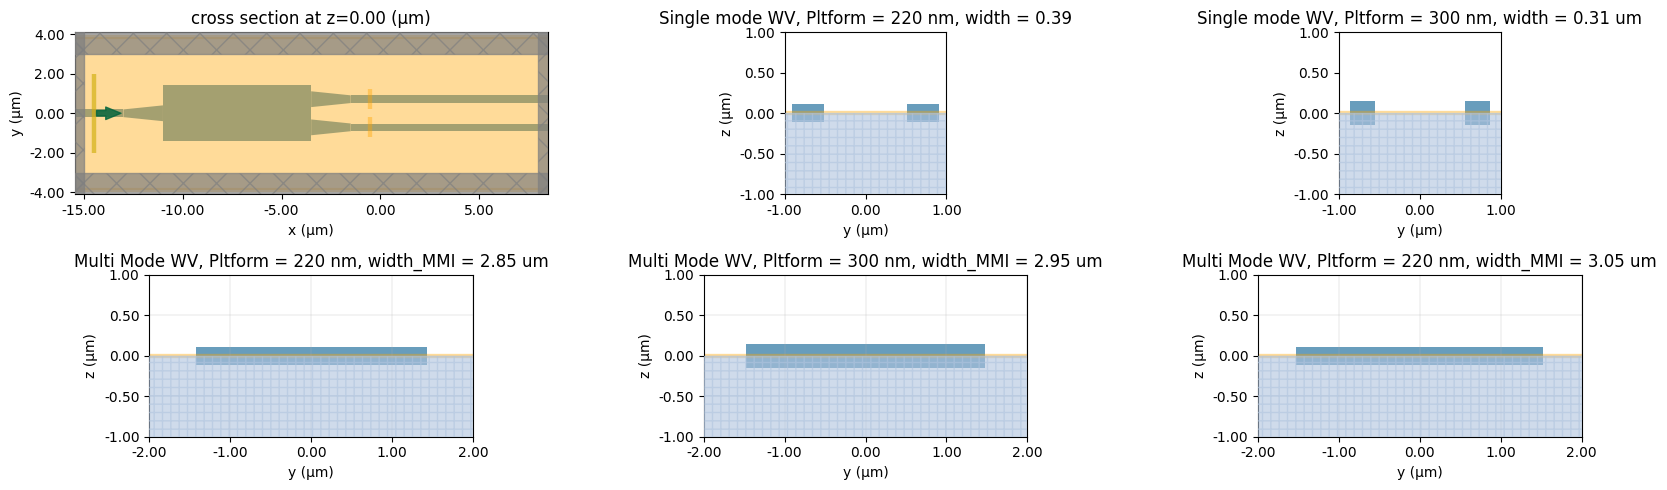

In [45]:
#------- Primer reto ---------

fig0, axes0 = plt.subplots(2, 3, figsize=(17, 5))
sim[0][0][0].plot(z = 0, lw=1, ax=axes0[0][0]) # Vista superior


sim[0][0][0].plot(x=0, lw=1, ax=axes0[0][1])   # Vista transversal Single mode waveguides a 220 nm , optimizado a 390 nm de width
axes0[0][1].set_xlim([-1, 1])
axes0[0][1].set_ylim([-1, 1])
axes0[0][1].set_title(f"Single mode WV, Pltform = {[220,300][0]} nm, width = {width_220}")


sim[1][0][0].plot(x=0, lw=1, ax=axes0[0][2])   # Vista transversal Single mode waveguides a 300 nm , optimizado a 310 nm de width
axes0[0][2].set_xlim([-1, 1])
axes0[0][2].set_ylim([-1, 1])
axes0[0][2].set_title(f"Single mode WV, Pltform = {[220,300][1]} nm, width = {width_300} um")

sim[0][0][0].plot(x=-5, lw=1, ax=axes0[1][0])
axes0[1][0].set_ylim([-1, 1])
axes0[1][0].set_xlim([-2, 2])
axes0[1][0].grid(True,linewidth = 0.2)
axes0[1][0].set_title(f"Multi Mode WV, Pltform = {[220,300][0]} nm, width_MMI = {sweep_MMI_W[0]} um")


sim[1][0][1].plot(x=-5, lw=1, ax=axes0[1][1])
axes0[1][1].set_ylim([-1, 1])
axes0[1][1].set_xlim([-2, 2])
axes0[1][1].grid(True,linewidth = 0.2)
axes0[1][1].set_title(f"Multi Mode WV, Pltform = {[220,300][1]} nm, width_MMI = {sweep_MMI_W[1]} um")


sim[0][0][2].plot(x=-5, lw=1, ax=axes0[1][2])
axes0[1][2].set_ylim([-1, 1])
axes0[1][2].set_xlim([-2, 2])
axes0[1][2].grid(True,linewidth = 0.2)
axes0[1][2].set_title(f"Multi Mode WV, Pltform = {[220,300][0]} nm, width_MMI = {sweep_MMI_W[2]} um")

plt.tight_layout()
plt.show()